# FENE beadspring with variable kuhn length experiment data analysis

In [1]:
import os

import plotly.colors

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.msd as plot_msd
import polyflexmd.data_analysis.plot.utils as plot_utils
import polyflexmd.data_analysis.data.constants as data_constants
import polyflexmd.data_analysis.pipelines.trajectory as pipeline_process
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.plot.msd
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
import scipy.optimize
import functools

import matplotlib.transforms

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style("darkgrid")

params = {
    'axes.labelsize': 10,
    'figure.dpi': 300,
    "figure.figsize": plot_utils.get_figure_size(width=1, n_rows=1)
}
plt.rcParams.update(params)


## Read and process data

In [4]:
PATH_EXPERIMENT = "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/538accb2"
NAME_EC = "4-FENE-beadspring-vary-l_K.toml"
EQUILIBRIUM_ONLY = True
CONTINUE = False
CONTINUE_t_equilibrium = 58000000
N_WORKERS = 16
CHECK_BOND_LENGTHS = False

In [5]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
EQUILIBRIUM_ONLY = bool(EQUILIBRIUM_ONLY)
CHECK_BOND_LENGTHS = bool(CHECK_BOND_LENGTHS)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC
N_WORKERS = int(N_WORKERS)

### Read experiment config

In [6]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='96:00:00', partition='romeo', nodes=8, tasks_per_node=125, ntasks=1000, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results'), n_partitions=8, n_tasks_per_partition=125, variables={'kappa_start': 1.0, 'kappa_delta': 10, 'kappa_n_values': 8, 'n_relax_steps': 30000000, 'n_equilibrium_steps_1': 2000000, 'dump_frequency_1': 100, 'n_equilibrium_steps_2': 33000000, 'dump_frequency_2': 10000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=

In [7]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 11.0, 21.0, 31.0, 41.0, 51.0, 61.0, 71.0]

### Read initial system

In [8]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

molecule-ID  type          x          y         z  ix  iy  iz
1                1     1   0.000000   0.000000  0.000000   0   0   0
2                1     1  -0.336178   0.186169  0.890632   0   0   0
3                1     2  -0.672356   0.372339  1.781264   0   0   0
4                1     2  -1.008534   0.558508  2.671896   0   0   0
5                1     2  -1.344712   0.744678  3.562528   0   0   0
...            ...   ...        ...        ...       ...  ..  ..  ..
31996          500     2  25.290807 -50.942120 -6.367762   0   0   0
31997          500     2  25.719465 -51.805546 -6.475690   0   0   0
31998          500     2  26.148122 -52.668972 -6.583618   0   0   0
31999          500     2  26.576780 -53.532397 -6.691547   0   0   0
32000          500     3  27.005438 -54.395823 -6.799475   0   0   0

[32000 rows x 8 columns]

In [9]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Read main-axis dataframe

In [10]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/538accb2/data/processed')

In [11]:
PATH_DF_MAIN_AXIS = PATH_DATA_PROCESSED / "main_axis.csv"
df_main_axis = pd.read_csv(PATH_DF_MAIN_AXIS).groupby("molecule-ID").nth(1)
df_main_axis

molecule-ID  type         x         y         z  ix  iy  iz
1              1     1 -0.336178  0.186169  0.890632   0   0   0
3              2     1 -0.272215 -0.119898  0.923268   0   0   0
5              3     1 -0.517323 -0.532615 -0.624178   0   0   0
7              4     1  0.302546 -0.396453  0.831980   0   0   0
9              5     1 -0.592061  0.192979  0.743722   0   0   0
..           ...   ...       ...       ...       ...  ..  ..  ..
991          496     1  0.301950 -0.674609 -0.628195   0   0   0
993          497     1 -0.010688  0.215110 -0.945787   0   0   0
995          498     1 -0.072238  0.104175  0.961680   0   0   0
997          499     1 -0.396090 -0.883587  0.057330   0   0   0
999          500     1  0.428658 -0.863426 -0.107928   0   0   0

[500 rows x 8 columns]

## Calculate and plot observables

In [12]:
l_b_src = .97
L_src = l_b_src * (conf.initial_system_config.system_config.n_monomers - 1)
L_src

61.11

### Color palette

In [44]:
kappa_colors = sns.color_palette("viridis", n_colors=len(kappas)+1)
kappa_colors

[(0.282623, 0.140926, 0.457517),
 (0.253935, 0.265254, 0.529983),
 (0.206756, 0.371758, 0.553117),
 (0.163625, 0.471133, 0.558148),
 (0.127568, 0.566949, 0.550556),
 (0.134692, 0.658636, 0.517649),
 (0.266941, 0.748751, 0.440573),
 (0.477504, 0.821444, 0.318195),
 (0.741388, 0.873449, 0.149561)]

### End-to-End distance $\vec{R}$

In [14]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"
df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "molecule-ID", "t"])
df_ete

R_x       R_y        R_z          R
kappa molecule-ID t                                                  
1.0   1           30000000   4.653390   7.51274   7.235560  11.421411
      2           30000000   5.183050   2.47633   9.489370  11.092537
      3           30000000   4.879620  -1.24165   8.614230   9.977843
      4           30000000   0.573486  -4.00533   3.909040   5.626024
      5           30000000  -2.084040  -6.83918   0.227633   7.153281
...                               ...       ...        ...        ...
71.0  496         65000000  32.172900 -46.69850 -10.628500  57.695847
      497         65000000  19.717800  37.38680 -38.115400  56.915268
      498         65000000 -42.031100  -7.32022  25.061500  49.480076
      499         65000000 -25.478400 -50.98580  15.163900  58.980034
      500         65000000  46.443500 -29.78540   7.322810  55.657818

[93204000 rows x 4 columns]

In [15]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x       R_y        R_z          R  \
kappa molecule-ID t                                                     
1.0   1           30000000   4.653390   7.51274   7.235560  11.421411   
      2           30000000   5.183050   2.47633   9.489370  11.092537   
      3           30000000   4.879620  -1.24165   8.614230   9.977843   
      4           30000000   0.573486  -4.00533   3.909040   5.626024   
      5           30000000  -2.084040  -6.83918   0.227633   7.153281   
...                               ...       ...        ...        ...   
71.0  496         65000000  32.172900 -46.69850 -10.628500  57.695847   
      497         65000000  19.717800  37.38680 -38.115400  56.915268   
      498         65000000 -42.031100  -7.32022  25.061500  49.480076   
      499         65000000 -25.478400 -50.98580  15.163900  58.980034   
      500         65000000  46.443500 -29.78540   7.322810  55.657818   

                                t/LJ          R^2  
kappa molecule-ID t                                
1.0   1           30000000   75000.0   130.448641  
      2           30000000   75000.0   123.044377  
      3           30000000   75000.0    99.557351  
      4           30000000   75000.0    31.652148  
      5           30000000   75000.0    51.169425  
...                              ...          ...  
71.0  496         65000000  162500.0  3328.810761  
      497         65000000  162500.0  3239.347732  
      498         65000000  162500.0  2448.277921  
      499         65000000  162500.0  3478.644411  
      500         65000000  162500.0  3097.792705  

[93204000 rows x 6 columns]

In [17]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2         l_K
kappa t                                
1.0   30000000   121.753577    1.854017
      30000100   122.022246    1.854017
      30000200   122.315529    1.854017
      30000300   122.462672    1.854017
      30000400   122.593975    1.854017
...                     ...         ...
71.0  64960000  2825.152344  136.770000
      64970000  2824.566295  136.770000
      64980000  2816.356893  136.770000
      64990000  2804.853668  136.770000
      65000000  2797.986697  136.770000

[186408 rows x 2 columns]

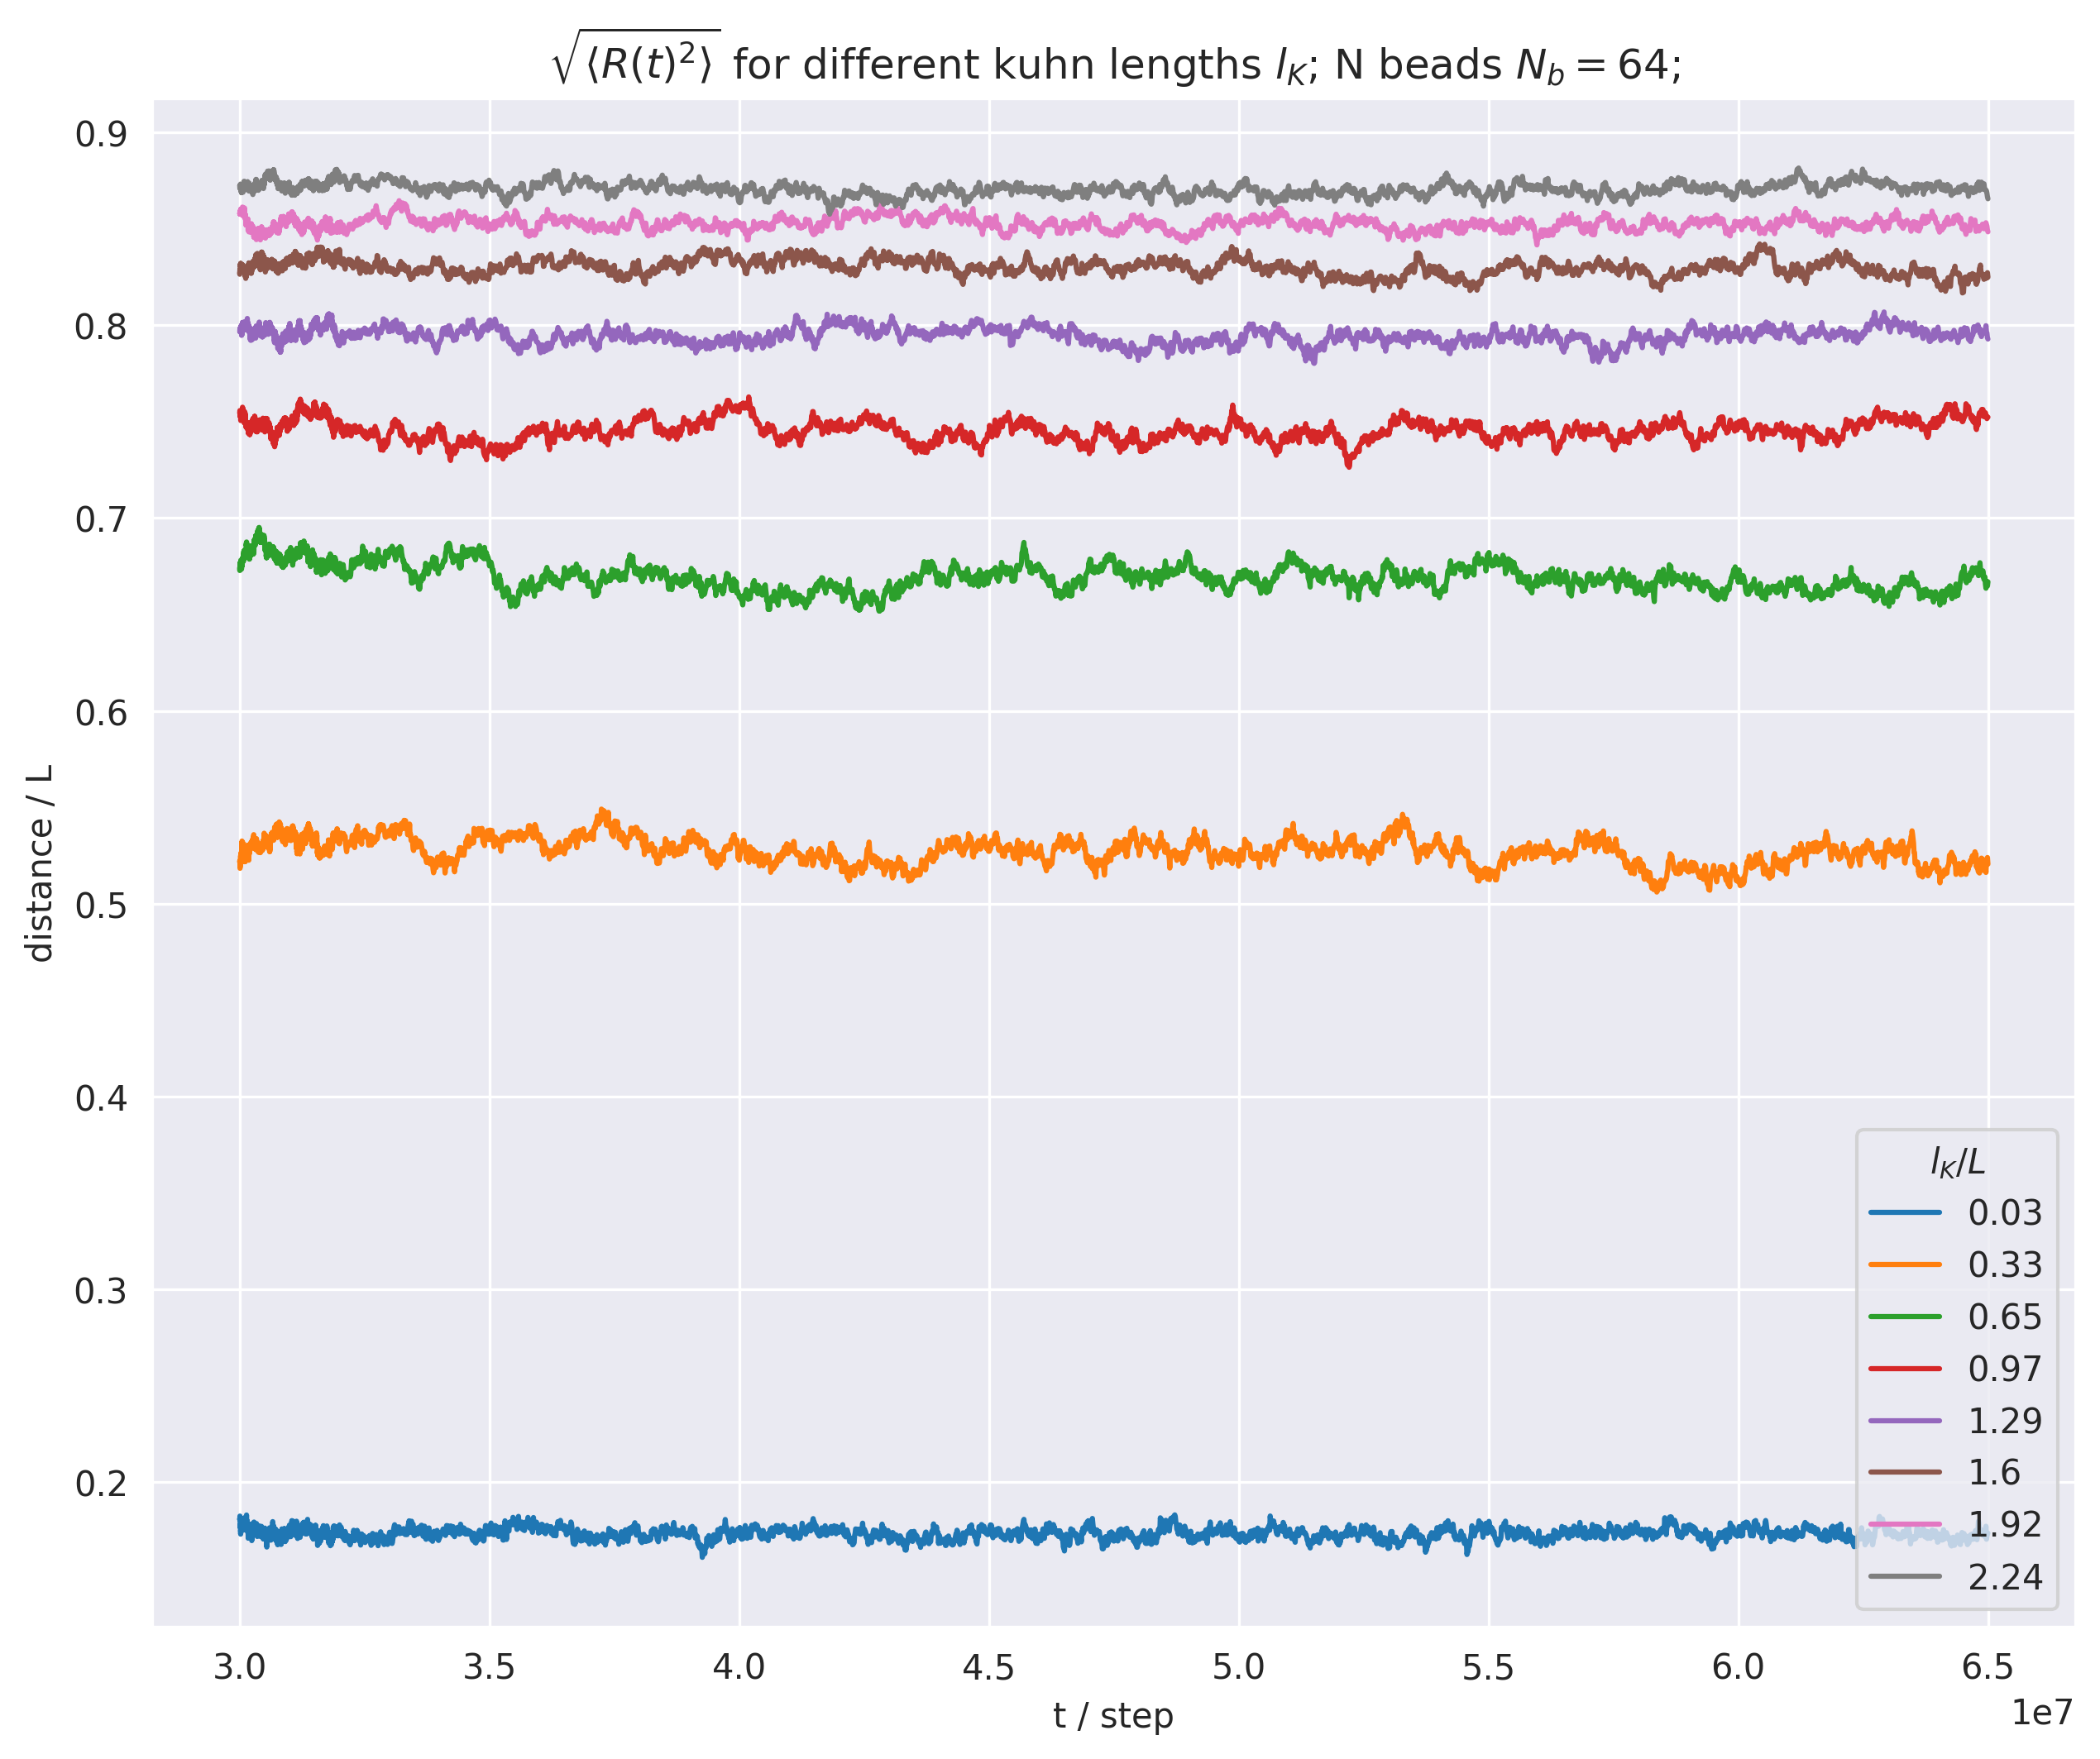

In [18]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10, 8))

ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"] / L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Equilibrium statistics

In [19]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

30000000

### Mean bond length

In [20]:
l_b = conf.initial_system_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [21]:
L_contour = l_b * (conf.initial_system_config.system_config.n_monomers - 1)
L_contour

61.11

### Kuhn lengths

Svaneborg (8)

In [22]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([  1.85401695,  20.37000013,  39.77      ,  59.17      ,
        78.57      ,  97.97      , 117.37      , 136.77      ])

Estimate from fit (Worm-like chain model, Hinczewski):

In [22]:
PATH_L_K_ESTIMATE = PATH_DATA_PROCESSED / "l_K-estimate.csv"
l_ks_estimate = pd.read_csv(PATH_L_K_ESTIMATE, index_col="kappa")
l_ks_estimate

t         l_K     d_l_K
kappa                                
1.0    30000000    1.686888  0.026178
11.0   30000000   20.290522  0.105991
21.0   30000000   40.452802  0.136657
31.0   30000000   61.616077  0.127580
41.0   30000000   78.770816  0.110465
...         ...         ...       ...
31.0   65000000   60.772934  0.111231
41.0   65000000   76.998405  0.134249
51.0   65000000   94.909123  0.248108
61.0   65000000  113.121888  0.179078
71.0   65000000  129.758617  0.332634

[186408 rows x 3 columns]

In [23]:
def aggregate_l_K_estimate(df: pd.DataFrame):
    l_K = df["l_K"].mean()
    d_l_K = df["l_K"] = df["l_K"].std() * 3
    return pd.Series([l_K, d_l_K], index=["l_K", "d_l_K"])


l_ks_estimate_agg = l_ks_estimate.groupby("kappa").apply(aggregate_l_K_estimate)
l_ks_estimate_agg

l_K      d_l_K
kappa                       
1.0      1.671224   0.046628
11.0    20.627271   1.062030
21.0    41.584460   4.017132
31.0    59.914476   5.426656
41.0    78.868018   6.045823
51.0   100.996739   8.289396
61.0   116.013684  10.383716
71.0   139.463155  12.719022

In [24]:
l_ks_estimate_agg / L_contour

l_K     d_l_K
kappa                    
1.0    0.027348  0.000763
11.0   0.337543  0.017379
21.0   0.680485  0.065736
31.0   0.980437  0.088801
41.0   1.290591  0.098933
51.0   1.652704  0.135647
61.0   1.898440  0.169918
71.0   2.282166  0.208133

Difference of analytical l_K and estimated l_K relative to analytical l_K

In [25]:
np.abs(l_ks - l_ks_estimate_agg["l_K"]) / l_ks

kappa
1.0     0.098593
11.0    0.012630
21.0    0.045624
31.0    0.012582
41.0    0.003793
51.0    0.030895
61.0    0.011556
71.0    0.019691
Name: l_K, dtype: float64

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [23]:
N_Ks = (L_contour / l_ks)
N_Ks

array([32.96086365,  2.99999998,  1.53658537,  1.03278689,  0.77777778,
        0.62376238,  0.52066116,  0.44680851])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [24]:
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean, t_equilibrium)
df_ete_sq_t_mean_kappas

R^2
kappa             
1.0     113.404773
11.0   1054.448004
21.0   1721.416559
31.0   2099.449019
41.0   2369.805322
51.0   2589.951859
61.0   2708.717934
71.0   2844.979417

### Summarize statistics by kappas

In [26]:
df_kuhn_summary = pd.DataFrame({
    "R^2": df_ete_sq_t_mean_kappas["R^2"],
    "N_K": N_Ks,
    "l_K": l_ks
}, index=df_ete_sq_t_mean_kappas.index)
df_kuhn_summary

R^2        N_K         l_K
kappa                                    
1.0     113.404773  32.960864    1.854017
11.0   1054.448004   3.000000   20.370000
21.0   1721.416559   1.536585   39.770000
31.0   2099.449019   1.032787   59.170000
41.0   2369.805322   0.777778   78.570000
51.0   2589.951859   0.623762   97.970000
61.0   2708.717934   0.520661  117.370000
71.0   2844.979417   0.446809  136.770000

In [29]:
df = df_kuhn_summary.copy().reset_index().drop(["R^2"], axis=1)
df["l_K"] = df["l_K"] / L_contour 
print(df.to_latex(header=True, index=False, float_format="%.2f"))

\begin{tabular}{rrr}
\toprule
kappa & N_K & l_K \\
\midrule
1.00 & 32.96 & 0.03 \\
11.00 & 3.00 & 0.33 \\
21.00 & 1.54 & 0.65 \\
31.00 & 1.03 & 0.97 \\
41.00 & 0.78 & 1.29 \\
51.00 & 0.62 & 1.60 \\
61.00 & 0.52 & 1.92 \\
71.00 & 0.45 & 2.24 \\
\bottomrule
\end{tabular}


In [35]:
L_contour / ((l_b / L_contour)*L_contour)

63.0

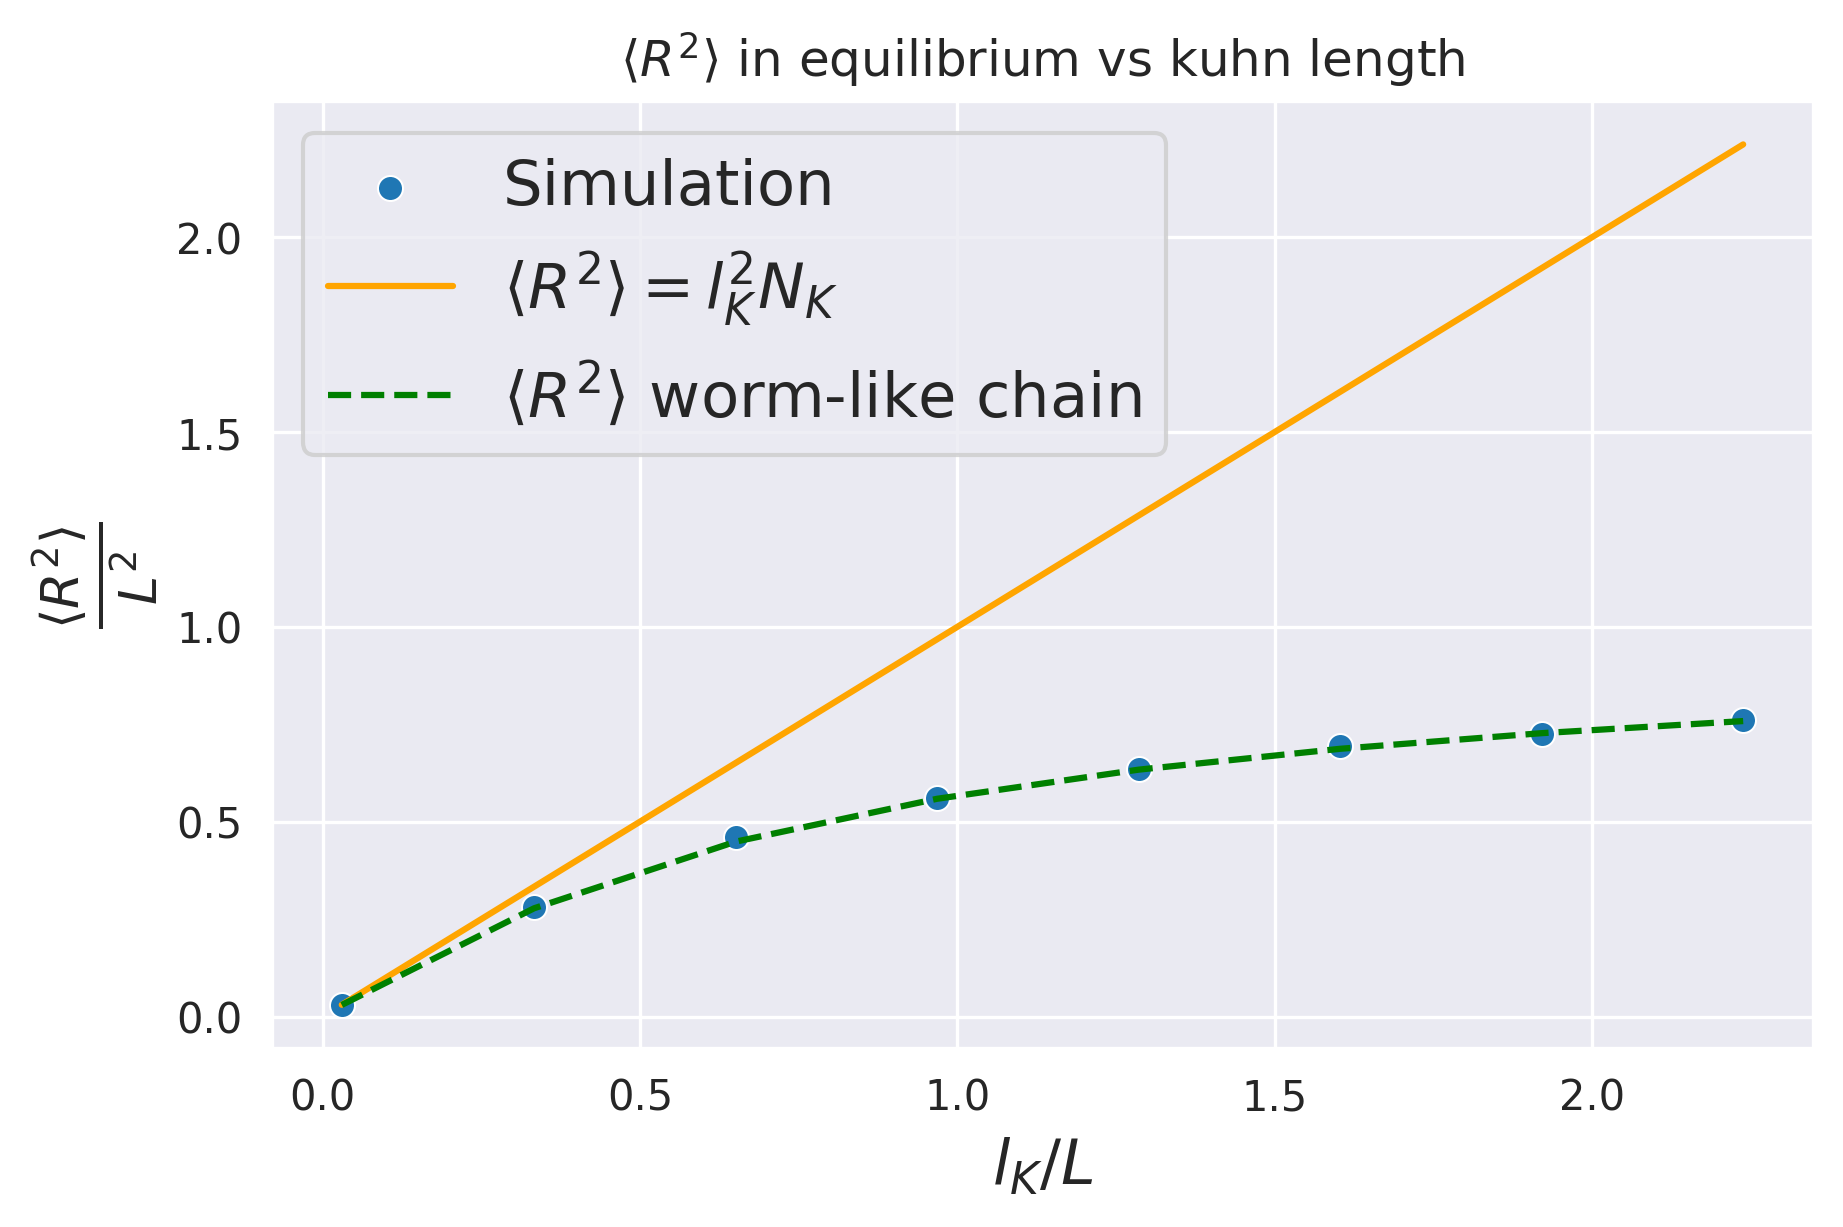

In [28]:
fig, ax = plt.subplots()

sns.scatterplot(
    x=df_kuhn_summary["l_K"] / L_contour,
    y=df_kuhn_summary["R^2"] / L_contour ** 2,
    ax=ax,
    label="Simulation"
)

sns.lineplot(
    x=df_kuhn_summary["l_K"] / L_contour,
    y=(df_kuhn_summary["l_K"] ** 2 * N_Ks) / L_contour ** 2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange"
)

l_ps = df_kuhn_summary["l_K"] / 2
Rs_wl_chain = 2*l_ps*L_contour - 2*l_ps**2 * (1 - np.exp(-L_contour / l_ps))

sns.lineplot(
    x=df_kuhn_summary["l_K"] / L_contour,
    y=Rs_wl_chain / L_contour ** 2,
    label=r"$\langle R^2 \rangle$ worm-like chain",
    color="green",
    linestyle="--"
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)

ax.legend(fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [36]:
import polyflexmd.data_analysis.transform.msd as msd

In [37]:
PATH_MSD = PATH_DATA_PROCESSED / "msd.csv"
PATH_MSD

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/538accb2/data/processed/msd.csv')

In [38]:
if PATH_MSD.exists():
    df_msd = pd.read_csv(PATH_MSD, index_col="t")
else:
    df_msd = msd.calculate_msd_df(df_ete, ["kappa"])
    df_msd["t/LJ"] = df_msd.index.map(lambda t: t * 0.0025)
    df_msd["t/LJ"] = df_msd["t/LJ"] - df_msd["t/LJ"].min()
    df_msd["l_K"] = kremer_grest.bare_kuhn_length(df_msd["kappa"], l_b=l_b)
    df_msd.to_csv(PATH_MSD, index=True)
df_msd

dR^2  delta dR^2  kappa      t/LJ         l_K
t                                                             
30000000     0.000000    0.000000    1.0      0.00    1.854017
30000100     0.131123    0.015256    1.0      0.25    1.854017
30000200     0.469626    0.050481    1.0      0.50    1.854017
30000300     0.925409    0.098095    1.0      0.75    1.854017
30000400     1.451558    0.156999    1.0      1.00    1.854017
...               ...         ...    ...       ...         ...
64960000  2170.061793  235.428868   71.0  87400.00  136.770000
64970000  2165.468234  236.485894   71.0  87425.00  136.770000
64980000  2169.143304  236.389463   71.0  87450.00  136.770000
64990000  2167.883654  235.034069   71.0  87475.00  136.770000
65000000  2192.788809  234.926677   71.0  87500.00  136.770000

[186408 rows x 5 columns]

In [52]:
df_msd_fullflex = pd.read_csv("/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free-angle/3-FENE-beadspring-free-angle/8b2b60a0/data/processed/msd.csv", index_col="t")
df_msd_fullflex["kappa"] = 0
df_msd_fullflex["l_K"] = l_b
df_msd_fullflex

dR^2  delta dR^2     t/LJ  kappa   l_K
t                                                    
0          0.000000    0.000000      0.0      0  0.97
10000     18.015540    1.946947     25.0      0  0.97
20000     25.799686    2.624198     50.0      0  0.97
30000     30.516514    3.345791     75.0      0  0.97
40000     35.349248    3.769812    100.0      0  0.97
...             ...         ...      ...    ...   ...
3960000  116.913197   12.873626   9900.0      0  0.97
3970000  118.318092   13.081599   9925.0      0  0.97
3980000  116.170760   12.936773   9950.0      0  0.97
3990000  112.412522   12.513329   9975.0      0  0.97
4000000  114.657569   12.848878  10000.0      0  0.97

[401 rows x 5 columns]

(<Figure size 1989.08x1229.32 with 1 Axes>, <Axes: >)

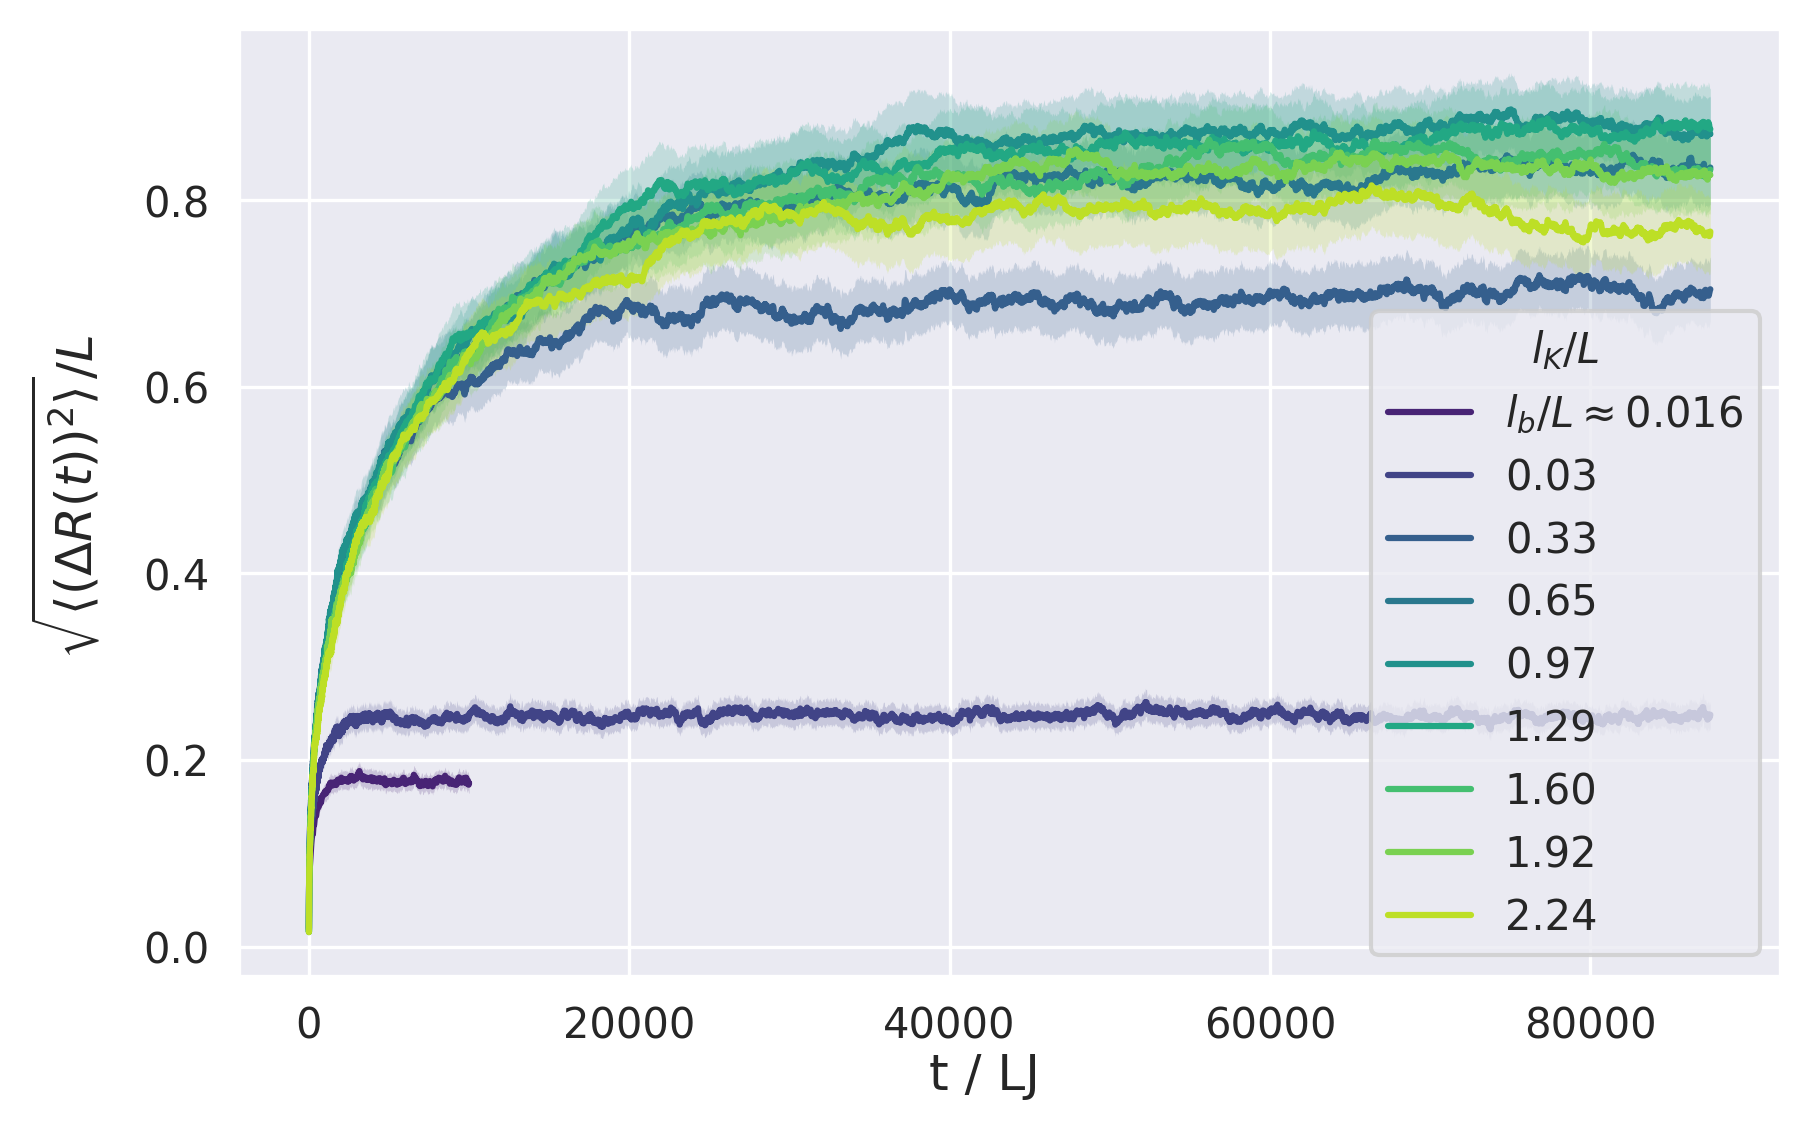

In [56]:
def plot_msd_fig(df: pd.DataFrame, display_suptitle: bool = True, log_scale: bool = False):
    df = df.reset_index()
    ax: plt.Axes
    fig: plt.Figure
    fig, ax = plt.subplots(figsize=plot_utils.get_figure_size(width=1.0), ncols=1)
    if display_suptitle:
        fig.suptitle(
            f'Empirical MSD for different kuhn lengths $l_K$;\n'
            f'$N_b={conf.initial_system_config.system_config.n_monomers};$'
            f'$\zeta_e=\zeta=1.0$'
        )
    fig.supxlabel("t / LJ")
    fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L $")
    
    
    for i, (kappa, df_kappa) in enumerate(df.groupby("kappa")):
        if kappa > 0:
            l_K = kremer_grest.bare_kuhn_length(kappa, l_b=l_b)
            label=f"{l_K/L_contour:.2f}"
        else:
            l_K = l_b
            label=f"$l_b/L \\approx {l_K/L_contour:.3f}$"
        plot_msd.plot_MSD(
            df_msd=df_kappa,
            log_scale=log_scale,
            l_K=l_K,
            L_contour=L_contour,
            zeta=1.0,
            zeta_e=1.0,
            title="",
            ax=ax,
            color=kappa_colors[i],
            xlabel="",
            ylabel="",
            scatter=False,
            label=label
        )
        
        ax.legend()
        ax.get_legend().set_title("$l_K/L$")
    
    #fig.legend(*axs[-1].get_legend_handles_labels(), ncol=8, loc='upper right', title="$l_K/L$", bbox_to_anchor=(0.983, 1.15), columnspacing=0.8, handletextpad=0.2, handlelength=1.8)
    #for txt in legend.get_texts():
    #    txt.set_ha("center") # horizontal alignment of text item
    #    txt.set_x(-100) # x-position
    #    txt.set_y(25) # y-position

    #fig.tight_layout()
    
    
    return fig, ax


plot_msd_fig(pd.concat([df_msd, df_msd_fullflex]), False)

(<Figure size 1989.08x1229.32 with 1 Axes>, <Axes: >)

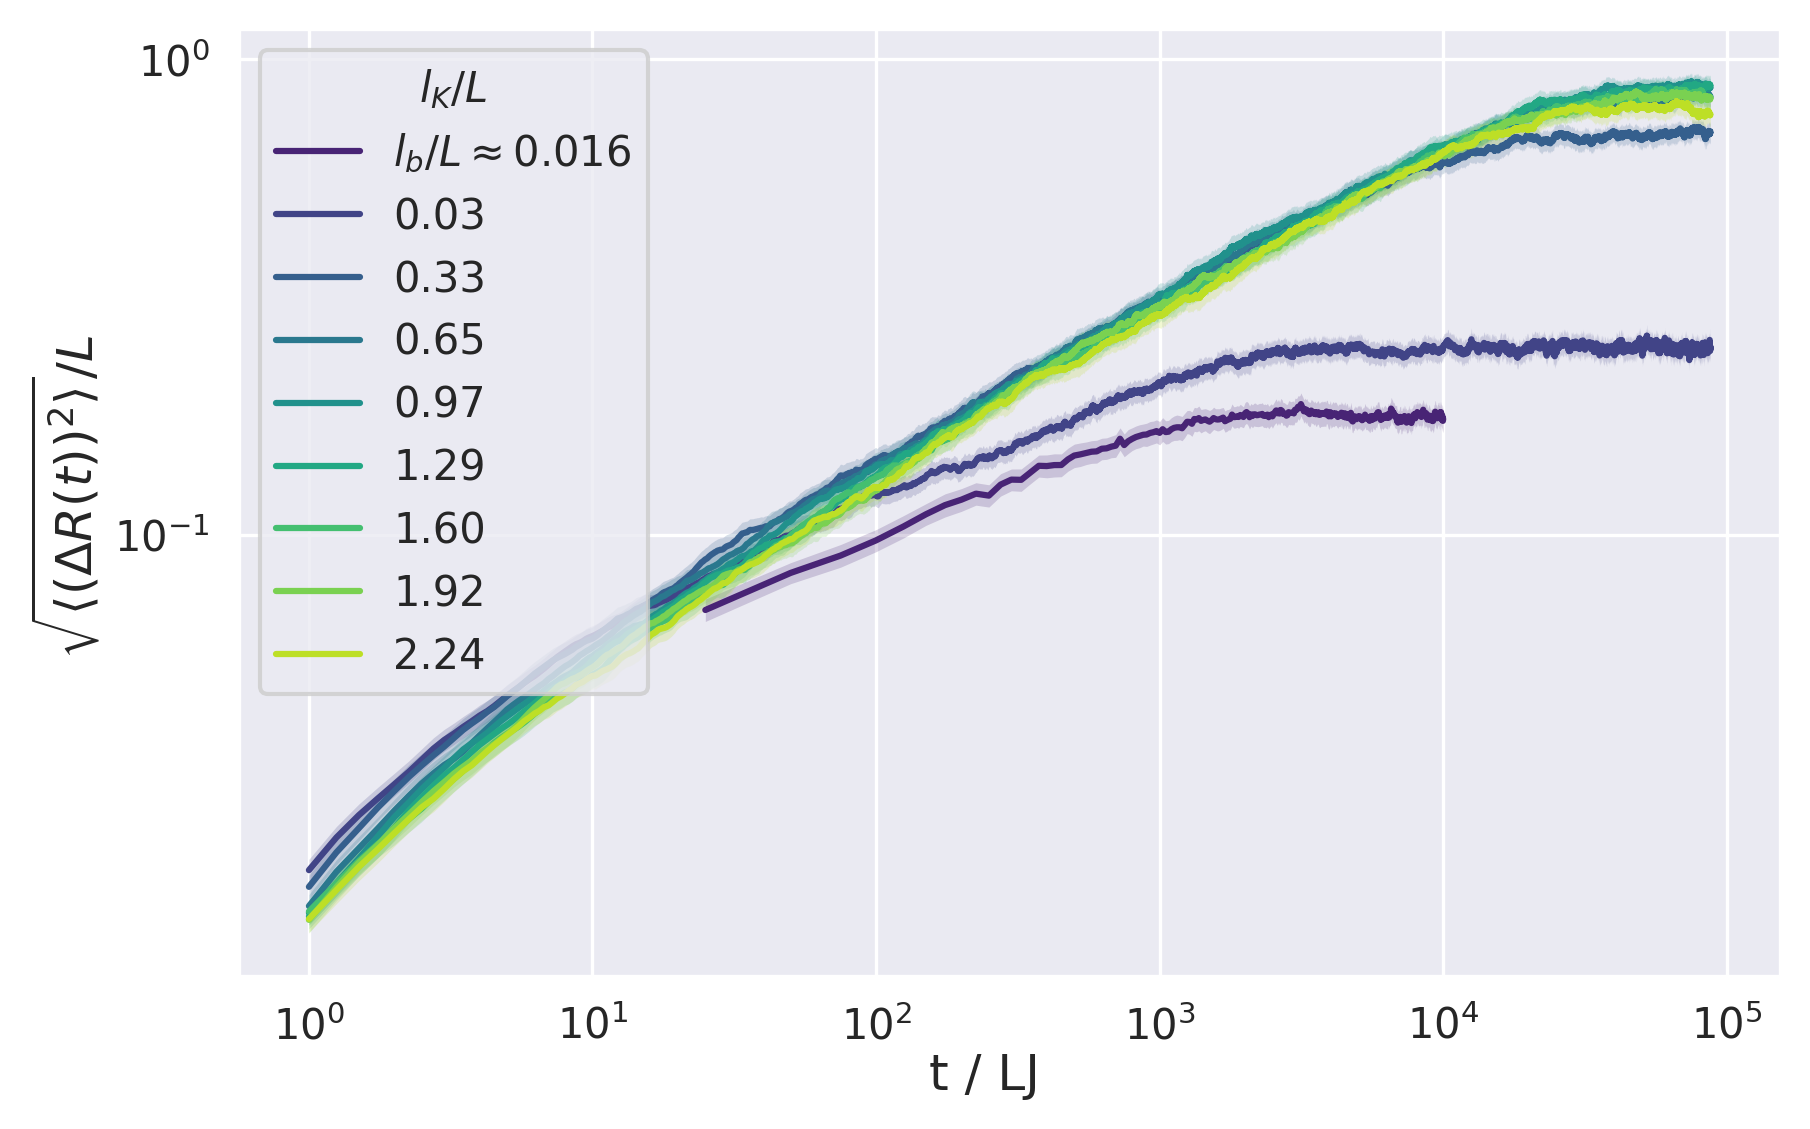

In [57]:
plot_msd_fig(pd.concat([df_msd, df_msd_fullflex]), False, True)

In [58]:
L_contour

61.11

## Research different dimensions of MSD

In [38]:
PATH_ETE_MAIN_AX = PATH_DATA_PROCESSED / "ete_main_ax.csv"

if PATH_ETE_MAIN_AX.exists():
    print("Reading ...")
    df_ete_main_ax_frame = pd.read_csv(PATH_ETE_MAIN_AX, index_col="t")
else:
    print("Processing ...")
    df_ete_main_ax_frame = transform.change_basis_df_ete(df_ete, df_main_axis)
    df_ete_main_ax_frame.to_csv(PATH_ETE_MAIN_AX, index=True)

df_ete_main_ax_frame

Reading ...


kappa  molecule-ID        R_x        R_y        R_z          R  \
t                                                                          
30000000    1.0            1   7.352342  -5.873343   6.472676  11.421411   
30000000   11.0            1   0.301723   6.699914   6.187263   9.124806   
30000000   21.0            1  14.893539  20.632757 -17.874411  31.096989   
30000000   31.0            1  40.844770   7.508727   6.804286  42.082950   
30000000   41.0            1 -10.612842  -9.343206  50.099404  52.056490   
...         ...          ...        ...        ...        ...        ...   
65000000   31.0          500 -46.747730 -22.830154   3.035810  52.113170   
65000000   41.0          500  23.882994   1.803430  -5.087860  24.485426   
65000000   51.0          500  38.260428  -4.190383  40.148024  55.617300   
65000000   61.0          500 -20.486125   4.428006  49.540542  53.791763   
65000000   71.0          500  29.002865 -10.960685  46.222175  55.657818   

              t/LJ          R^2  
t                                
30000000   75000.0   130.448641  
30000000   75000.0    83.262085  
30000000   75000.0   967.022725  
30000000   75000.0  1770.974681  
30000000   75000.0  2709.878151  
...            ...          ...  
65000000  162500.0  2715.782487  
65000000  162500.0   599.536086  
65000000  162500.0  3093.284059  
65000000  162500.0  2893.553767  
65000000  162500.0  3097.792705  

[93204000 rows x 8 columns]

In [39]:
df_msd_by_dim = msd.calculate_msd_by_dimension_df(
    df_ete=df_ete_main_ax_frame,
    group_by_params=["kappa"]
)
df_msd_by_dim["t/LJ"] = df_msd_by_dim.index.get_level_values("t").map(lambda t: t * 0.0025)
df_msd_by_dim["t/LJ"] = df_msd_by_dim["t/LJ"] - df_msd_by_dim["t/LJ"].min()
df_msd_by_dim

dR_x^2      dR_y^2      dR_z^2  delta dR_x^2  delta dR_y^2  \
t                                                                          
30000000    0.000000    0.000000    0.000000      0.000000      0.000000   
30000100    0.043648    0.043845    0.043629      0.008196      0.008455   
30000200    0.160976    0.158379    0.150270      0.030678      0.028299   
30000300    0.328723    0.305916    0.290770      0.062211      0.053110   
30000400    0.529745    0.471166    0.450647      0.101122      0.082558   
...              ...         ...         ...           ...           ...   
64960000  968.901091  864.891465  336.269238    160.643409    156.671159   
64970000  958.747908  866.253213  340.467113    158.797716    159.283156   
64980000  959.808591  870.472146  338.862566    160.472304    158.438912   
64990000  951.824845  881.303638  334.755171    159.542612    158.422890   
65000000  958.735727  881.134346  352.918737    159.537063    157.088799   

          delta dR_z^2         dR^2  kappa      t/LJ  
t                                                     
30000000      0.000000     0.000000    1.0      0.00  
30000100      0.008284     0.131123    1.0      0.25  
30000200      0.027057     0.469626    1.0      0.50  
30000300      0.053173     0.925409    1.0      0.75  
30000400      0.084038     1.451558    1.0      1.00  
...                ...          ...    ...       ...  
64960000     70.279715  2170.061793   71.0  87400.00  
64970000     71.459793  2165.468234   71.0  87425.00  
64980000     69.557689  2169.143304   71.0  87450.00  
64990000     68.331356  2167.883654   71.0  87475.00  
65000000     72.783077  2192.788809   71.0  87500.00  

[186408 rows x 9 columns]

### Different dimensions of same $l_K$

Text(0.02, 0.5, '$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$')

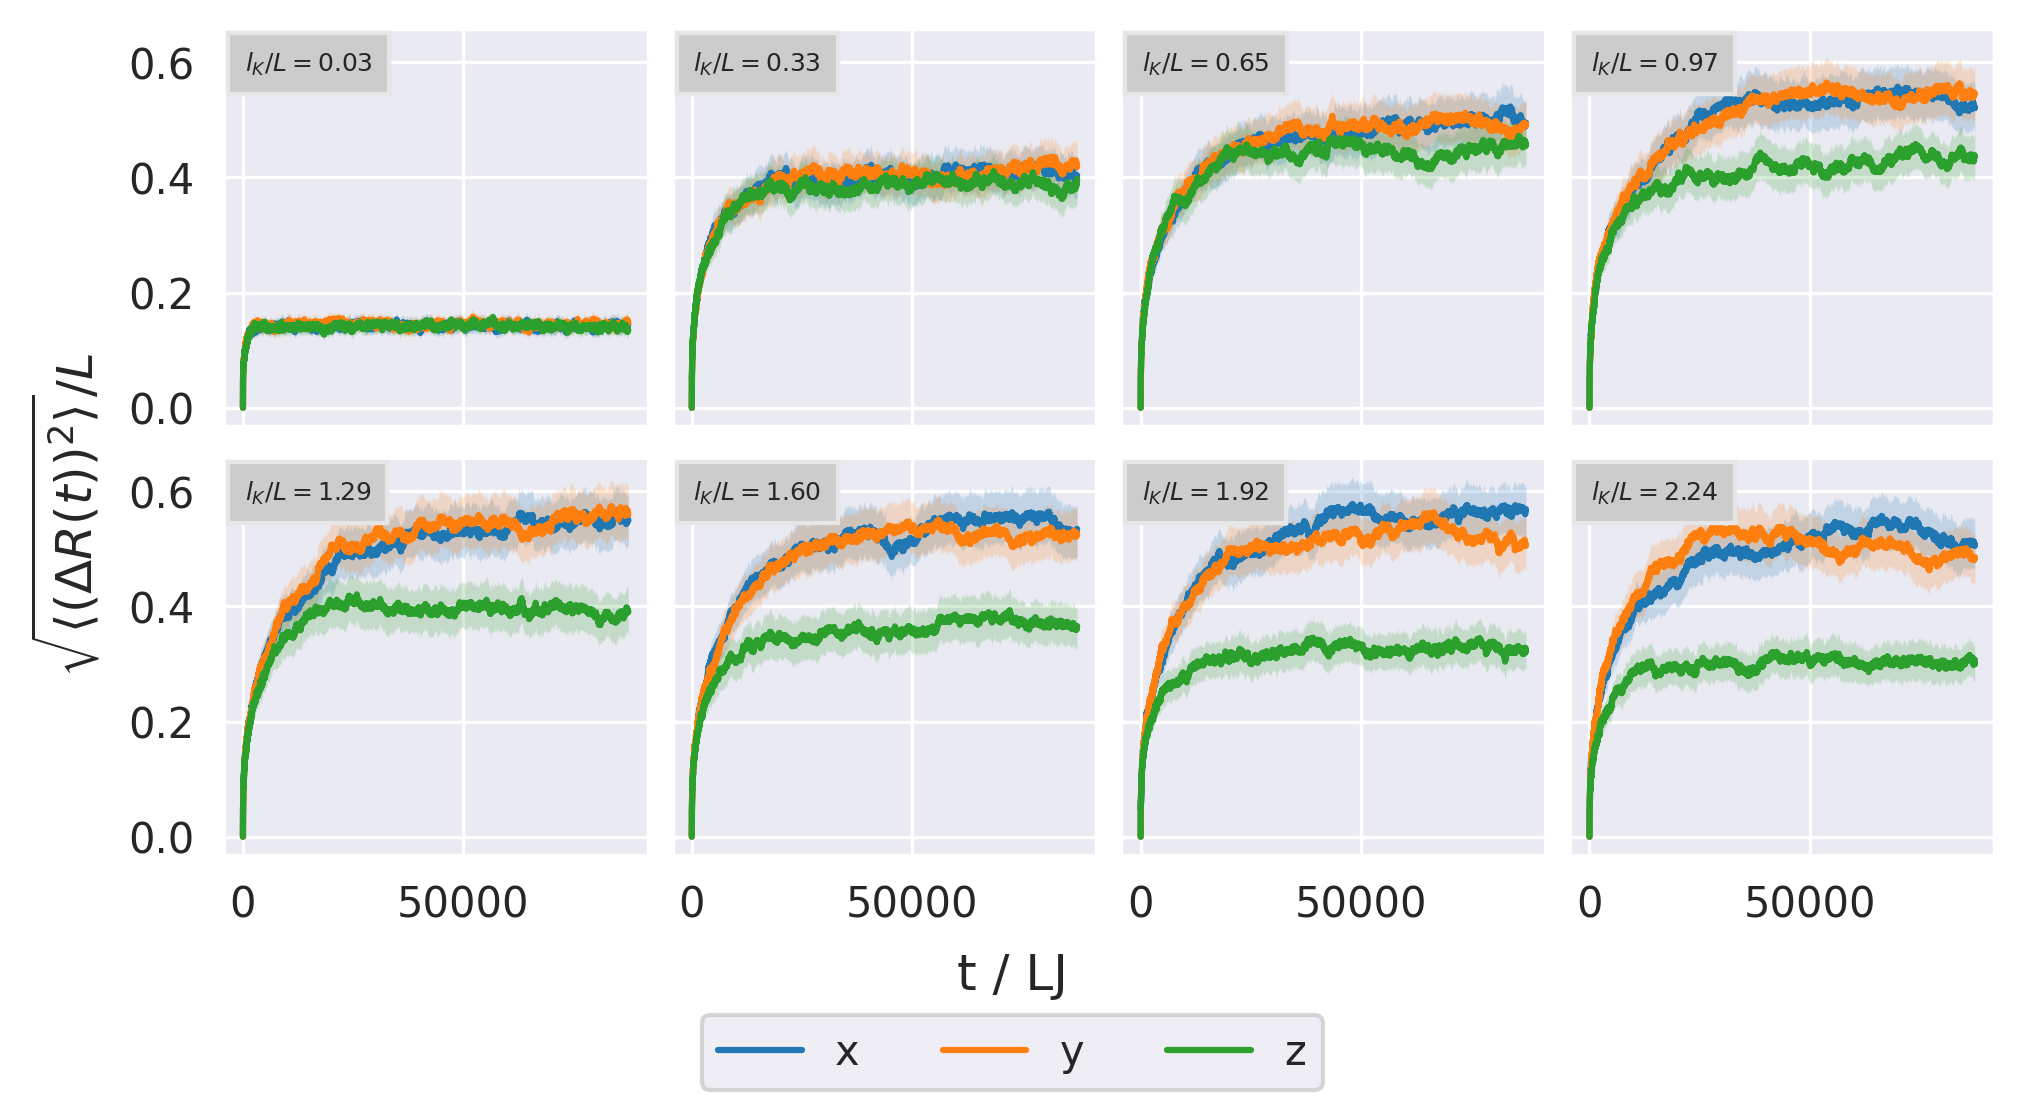

In [40]:
import matplotlib.transforms as mtransforms

fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=plot_utils.get_figure_size(width=1.0, n_rows=2, n_cols=4, height=0.5), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()
dimensions = ["x", "y", "z"]

for (kappa, df_g), ax in zip(df_msd_by_dim.groupby("kappa"), axs.flat):
    for dim in dimensions:
        l_K = kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour
        y = np.sqrt(df_g[f"dR_{dim}^2"]) / L_contour
        dy = df_g[f"delta dR_{dim}^2"] / (np.sqrt(df_g[f"dR_{dim}^2"]) * L_contour * 2)
        label = f"$l_K / L = {l_K : .2f}$"
        trans = mtransforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize=6, verticalalignment='top',
                bbox=dict(facecolor='0.8', edgecolor='0.9'))
        ax.plot(
            df_g["t/LJ"],
            y,
            label=dim,
            #path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()]
        )
        ax.fill_between(
            x=df_g["t/LJ"],
            y1=y - dy,
            y2=y + dy,
            alpha=.2,
            linewidth=0
        )
        ax.legend().set_visible(False)

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
#fig.suptitle(f"MSD for different dimensions; z || 1. bond; $\zeta_e = \zeta = 1.0$; L = {L_contour : .2f}")

Text(0.02, 0.5, '$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$')

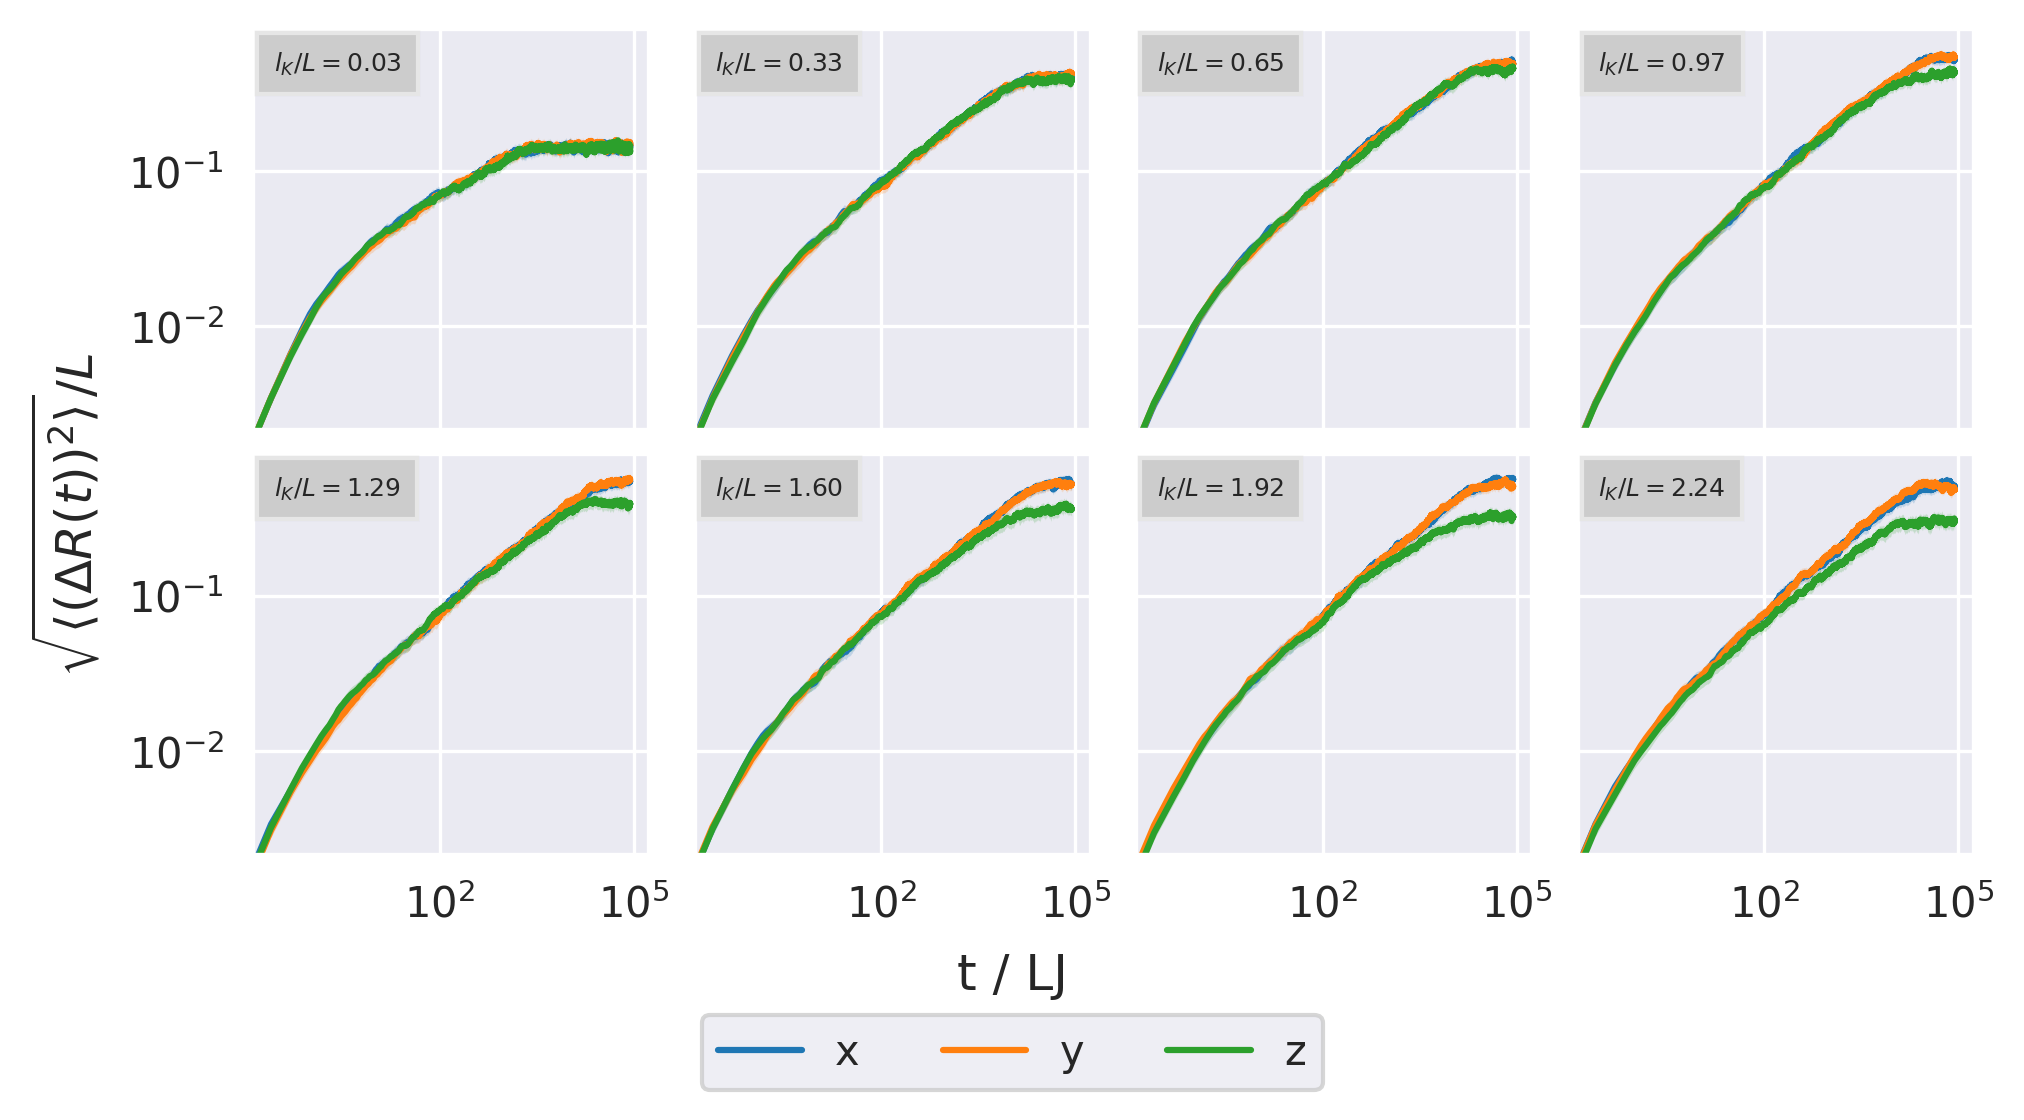

In [41]:
fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=plot_utils.get_figure_size(width=1.0, n_rows=2, n_cols=4, height=0.5), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()
dimensions = ["x", "y", "z"]

for (kappa, df_g), ax in zip(df_msd_by_dim.groupby("kappa"), axs.flat):
    for dim in dimensions:
        l_K = kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour
        y = np.sqrt(df_g[f"dR_{dim}^2"]) / L_contour
        dy = df_g[f"delta dR_{dim}^2"] / (np.sqrt(df_g[f"dR_{dim}^2"]) * L_contour * 2)
        label = f"$l_K / L = {l_K : .2f}$"
        trans = mtransforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize=6, verticalalignment='top',
                bbox=dict(facecolor='0.8', edgecolor='0.9'))
        ax.plot(
            df_g["t/LJ"],
            y,
            label=dim,
            #path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()]
        )
        ax.fill_between(
            x=df_g["t/LJ"],
            y1=y - dy,
            y2=y + dy,
            alpha=.2,
            linewidth=0
        )
        ax.legend().set_visible(False)
        ax.set(xscale="log", yscale="log")

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
# fig.suptitle(f"MSD for different dimensions; z || 1. bond; $\zeta_e = \zeta = 1.0$; L = {L_contour : .2f}")

### Different $l_K$'s of same dimension

Text(0.02, 0.5, 'distance/L')

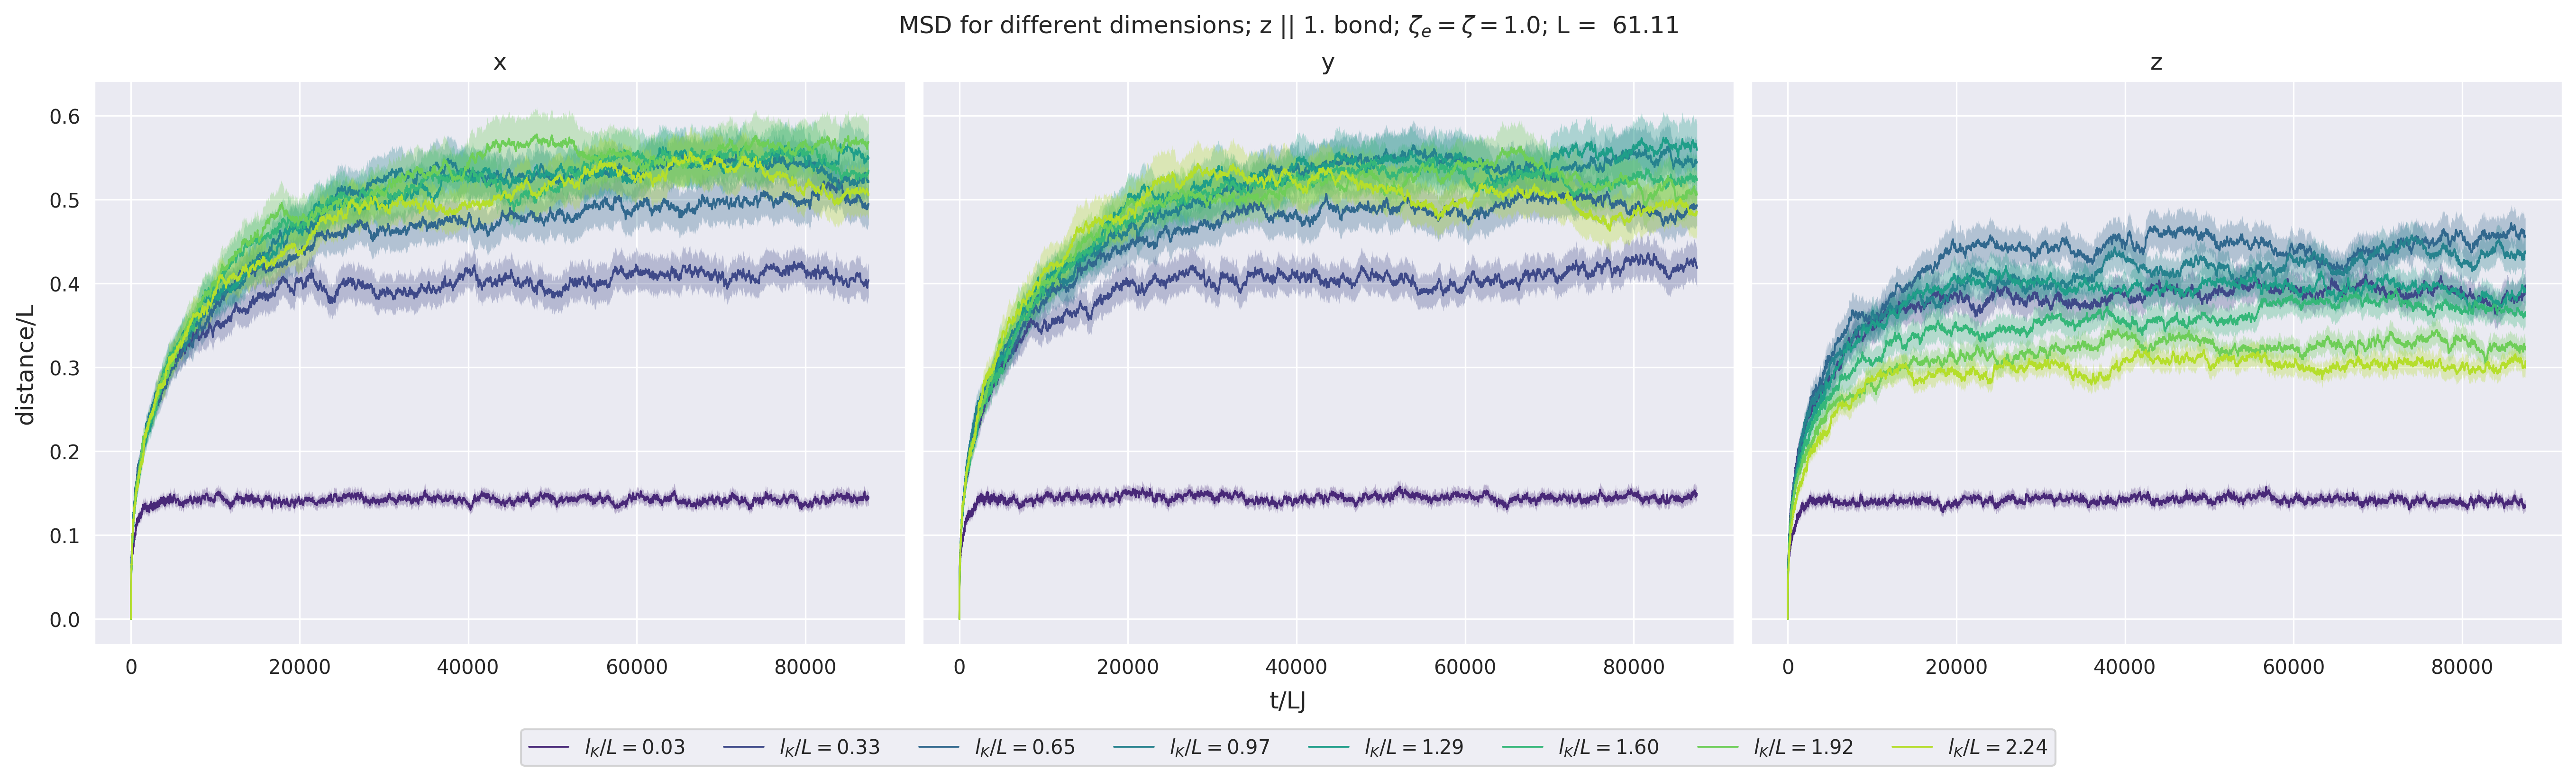

In [42]:
fig: plt.Figure
fig, axs = plt.subplots(ncols=len(dimensions), nrows=1, figsize=(18, 5), sharey="all", layout="constrained")
axs = axs.flatten()


def _plot(ax, dim):
    for i, (kappa, df_kappa) in enumerate(df_msd_by_dim.groupby("kappa")):
        y = np.sqrt(df_kappa[f"dR_{dim}^2"]) / L_contour
        dy = df_kappa[f"delta dR_{dim}^2"] / (np.sqrt(df_kappa["dR^2"]) * L_contour * 2)
        l_K = kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour
        ax.plot(
            df_kappa["t/LJ"],
            y,
            c=kappa_colors[i],
            label=f"$l_K/L = {l_K : .2f}$",
            linewidth=.9
        )
        ax.fill_between(
            x=df_kappa["t/LJ"],
            y1=y - dy,
            y2=y + dy,
            color=kappa_colors[i],
            alpha=.3,
            linewidth=0
        )

    ax.set(title=f"{dim}")


for dim, ax in zip(dimensions, axs):
    _plot(ax, dim)

_ = fig.legend(*axs[-1].get_legend_handles_labels(), ncol=8, loc='lower center', bbox_to_anchor=(0.5, -0.08))
fig.suptitle(f"MSD for different dimensions; z || 1. bond; $\zeta_e = \zeta = 1.0$; L = {L_contour : .2f}")
fig.supxlabel("t/LJ")
fig.supylabel("distance/L")


Text(0.02, 0.5, 'distance/L')

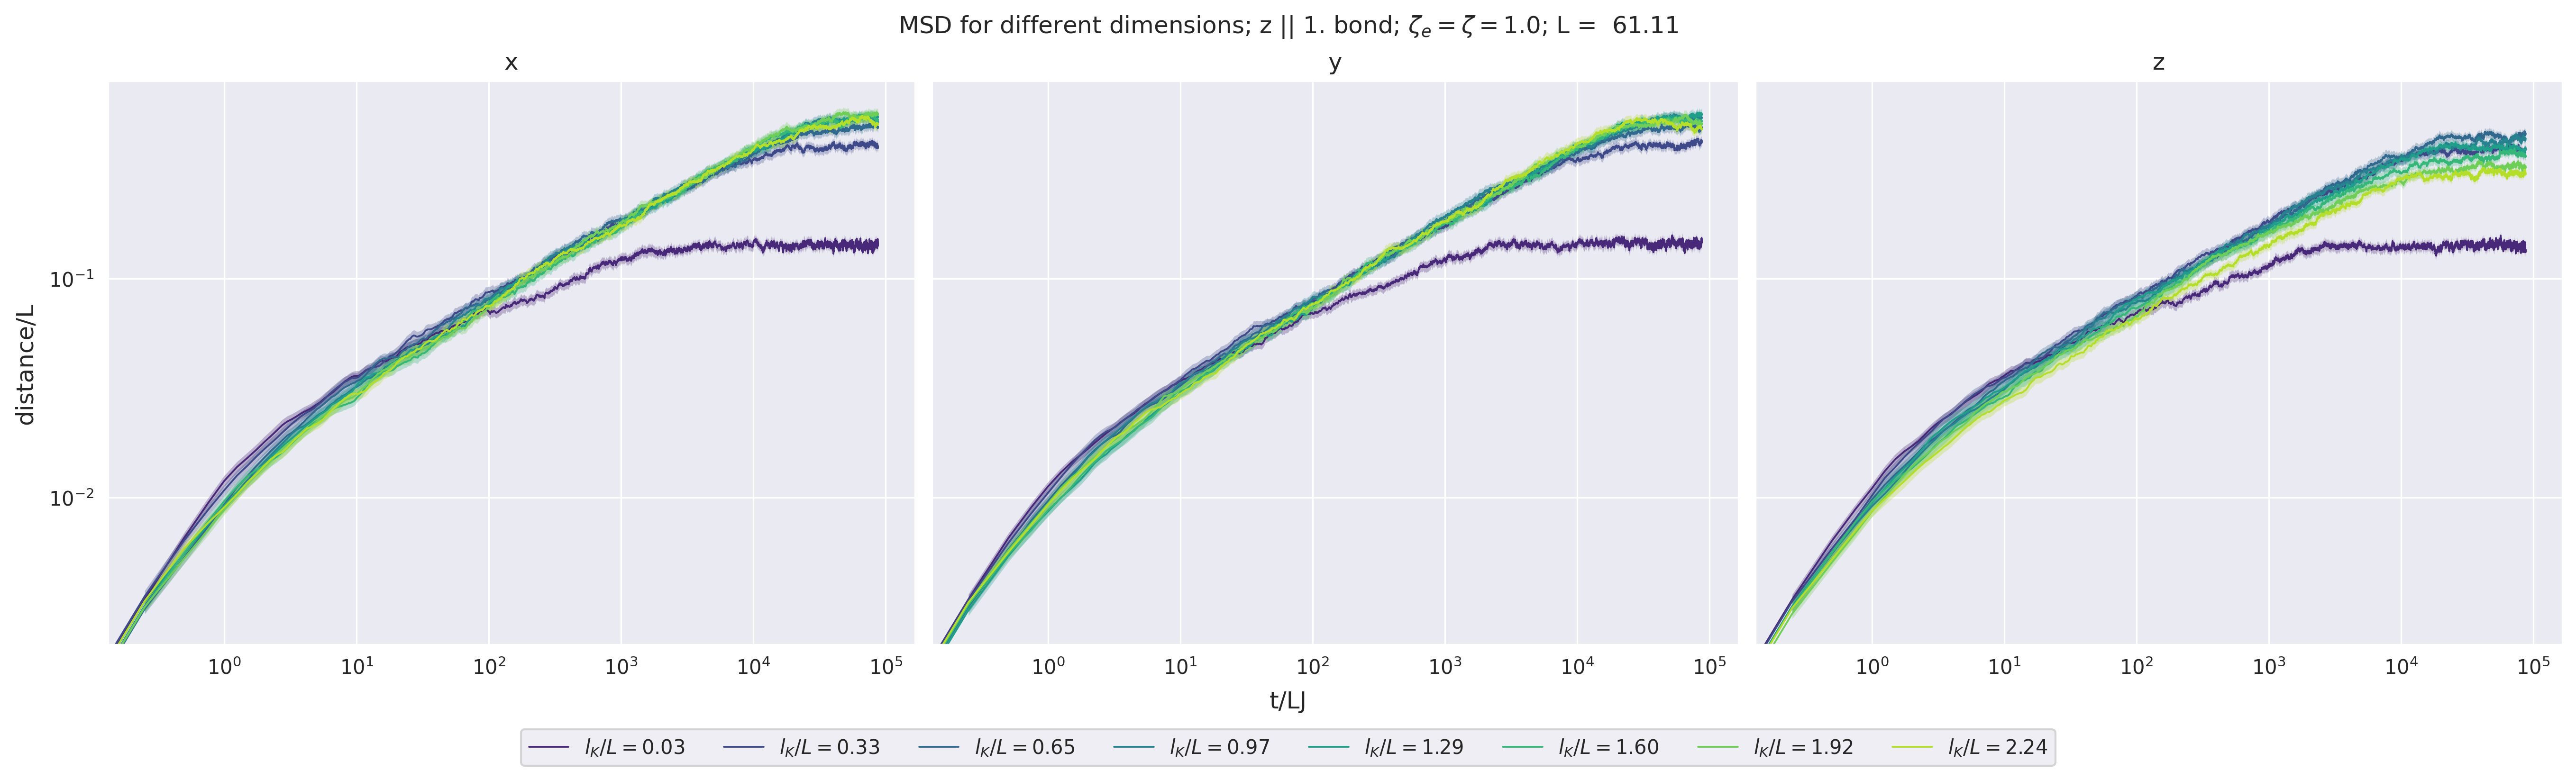

In [43]:
fig: plt.Figure
fig, axs = plt.subplots(ncols=len(dimensions), nrows=1, figsize=(18, 5), sharey="all", layout="constrained")
axs = axs.flatten()


def _plot(ax, dim):
    for i, (kappa, df_kappa) in enumerate(df_msd_by_dim.groupby("kappa")):
        y = np.sqrt(df_kappa[f"dR_{dim}^2"]) / L_contour
        dy = df_kappa[f"delta dR_{dim}^2"] / (np.sqrt(df_kappa["dR^2"]) * L_contour * 2)
        l_K = kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour
        ax.plot(
            df_kappa["t/LJ"],
            y,
            c=kappa_colors[i],
            label=f"$l_K/L = {l_K : .2f}$",
            linewidth=.9
        )
        ax.fill_between(
            x=df_kappa["t/LJ"],
            y1=y - dy,
            y2=y + dy,
            color=kappa_colors[i],
            alpha=.3,
            linewidth=0
        )

    ax.set(title=f"{dim}")
    ax.set(xscale="log", yscale="log")


for dim, ax in zip(dimensions, axs):
    _plot(ax, dim)

_ = fig.legend(*axs[-1].get_legend_handles_labels(), ncol=8, loc='lower center', bbox_to_anchor=(0.5, -0.08))
fig.suptitle(f"MSD for different dimensions; z || 1. bond; $\zeta_e = \zeta = 1.0$; L = {L_contour : .2f}")
fig.supxlabel("t/LJ")
fig.supylabel("distance/L")

## Compare with Rouse model


### Analytical $\tau_R$

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta_K N_K l_K^2}{k_B T} = \frac{1}{3 \pi^2} \frac{\zeta N_b N_K l_K^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{3 \pi^2 \tau_R}{N_K^2} $$

In [44]:
zeta = 1  # LJ
T = 1
k_B = 1
alpha = 4.047

rouse_times_analytical = []
for i, (l_K, N_K, R_sq) in enumerate(zip(df_kuhn_summary["l_K"], df_kuhn_summary["N_K"], df_kuhn_summary["R^2"])):
    tau_R_analytical = zeta * conf.initial_system_config.system_config.n_monomers * N_K * l_K ** 2 / (
            3 * np.pi ** 2 * k_B * T)
    tau_R_analytical_corrected = tau_R_analytical * alpha
    rouse_times_analytical.append(tau_R_analytical_corrected)

df_rouse_times_theory = pd.DataFrame({
    "l_K": df_kuhn_summary["l_K"],
    "N_K": df_kuhn_summary["N_K"],
    "Theory tau_R": rouse_times_analytical,
    "Theory tau_0": (rouse_times_analytical / df_kuhn_summary["N_K"] ** 2) * 3 * np.pi**2
}, index=df_kuhn_summary.index)

df_rouse_times_theory

l_K        N_K  Theory tau_R  Theory tau_0
kappa                                                   
1.0      1.854017  32.960864    991.101568  2.701108e+01
11.0    20.370000   3.000000  10889.187947  3.582399e+04
21.0    39.770000   1.536585  21259.842998  2.666046e+05
31.0    59.170000   1.032787  31630.498119  8.780224e+05
41.0    78.570000   0.777778  42001.153240  2.055754e+06
51.0    97.970000   0.623762  52371.808361  3.985476e+06
61.0   117.370000   0.520661  62742.463482  6.852866e+06
71.0   136.770000   0.446809  73113.118603  1.084360e+07

Text(0.02, 0.5, '$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$')

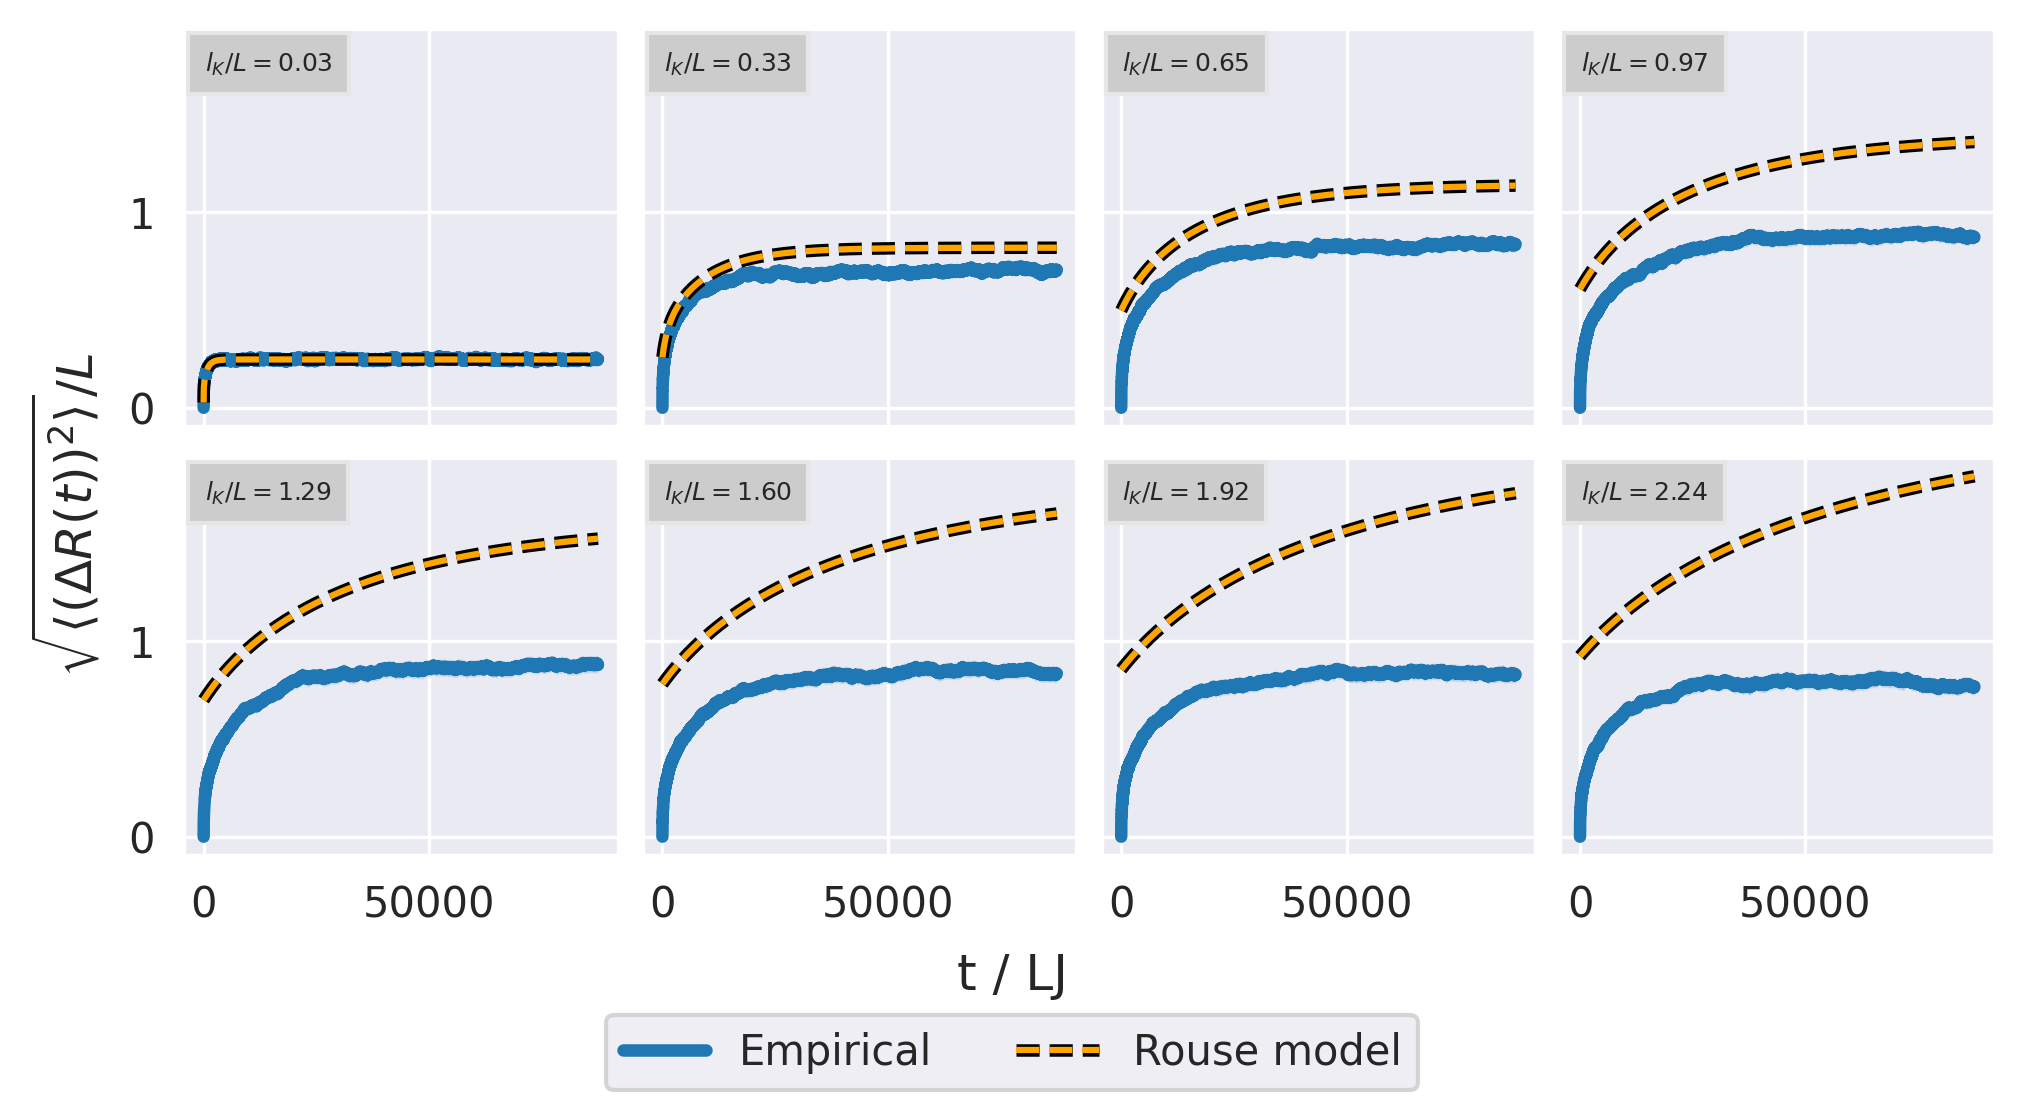

In [45]:
import matplotlib.patheffects as pe

fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=plot_utils.get_figure_size(width=1.0, n_rows=2, n_cols=4, height=0.5), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()

for i, (kappa, df_g) in enumerate(df_msd.groupby("kappa")):
    ax = axs[i]
    l_K = kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour
    y = np.sqrt(df_g[f"dR^2"]) / L_contour
    dy = df_g[f"delta dR^2"] / (np.sqrt(df_g[f"dR^2"]) * L_contour * 2)
    label = f"$l_K / L = {l_K : .2f}$"
    trans = matplotlib.transforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)

    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=6, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='0.9'))

    ax.plot(
        df_g["t/LJ"],
        y,
        label="Empirical",
        linewidth=3
    )

    ax.fill_between(
        x=df_g["t/LJ"],
        y1=y - dy,
        y2=y + dy,
        alpha=.2,
        linewidth=0
    )

    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_theory.loc[kappa]["Theory tau_R"]

    p_max = 1 if N_K < 1 else int(round(N_K))

    rouse_predictions = rouse.rouse_g_4(
        t=df_g["t/LJ"],
        tau_R=tau_R,
        p_max=p_max,
        N_b=N_K,
        l_b=l_K * L_contour
    )

    ax.plot(
        df_g["t/LJ"],
        np.sqrt(rouse_predictions) / L_contour,
        linestyle="dashed",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()],
        label="Rouse model",
        color="orange",
    )

    ax.legend().set_visible(False)

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
#fig.suptitle(f"Comparison empirical MSD with Rouse model for different kuhn lengths $l_K$; $\zeta_e = \zeta = 1.0$; L = {L_contour : .2f}")

### Fit $\tau_R$

In [46]:

df_rouse_times_fit = []

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_msd.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4, N_b=N_K, l_b=l_K, p_max=conf.initial_system_config.system_config.n_monomers),
        df_ete_change_kappas_equi_kappa.loc[df_ete_change_kappas_equi_kappa["t/LJ"] < 1e4]["t/LJ"],
        df_ete_change_kappas_equi_kappa[df_ete_change_kappas_equi_kappa["t/LJ"] < 1e4]["dR^2"],
        p0=(10 ** (i + 1),) if i != 0 else 100
    )
    df_rouse_times_fit.append((kappa, popt[0], np.sqrt(np.diag(pcov))[0], l_K, N_K))

df_rouse_times_fit = pd.DataFrame(
    df_rouse_times_fit,
    columns=["kappa", "Empirical tau_R", "Empirical Delta tau_R", "l_K", "N_K"]
).set_index("kappa")

df_rouse_times_fit["Empirical tau_0"] = df_rouse_times_fit["Empirical tau_R"] / df_rouse_times_fit["N_K"] ** 2
df_rouse_times_fit["Empirical Delta tau_0"] = df_rouse_times_fit["Empirical Delta tau_R"] / df_rouse_times_fit[
    "N_K"] ** 2

df_rouse_times_fit

Empirical tau_R  Empirical Delta tau_R         l_K        N_K  \
kappa                                                                  
1.0         953.318324               0.719159    1.854017  32.960864   
11.0      17978.154608              15.117218   20.370000   3.000000   
21.0      61946.513031              63.345018   39.770000   1.536585   
31.0     130929.255556             123.814540   59.170000   1.032787   
41.0     264613.191612             333.798881   78.570000   0.777778   
51.0     445213.323751             527.801071   97.970000   0.623762   
61.0     640515.582079             755.887583  117.370000   0.520661   
71.0     903600.632731            1224.359624  136.770000   0.446809   

       Empirical tau_0  Empirical Delta tau_0  
kappa                                          
1.0       8.774872e-01               0.000662  
11.0      1.997573e+03               1.679691  
21.0      2.623635e+04              26.828666  
31.0      1.227482e+05             116.078081  
41.0      4.374218e+05             551.789987  
51.0      1.144273e+06            1356.537849  
61.0      2.362759e+06            2788.347215  
71.0      4.526199e+06            6132.903424

Text(0.02, 0.5, '$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$')

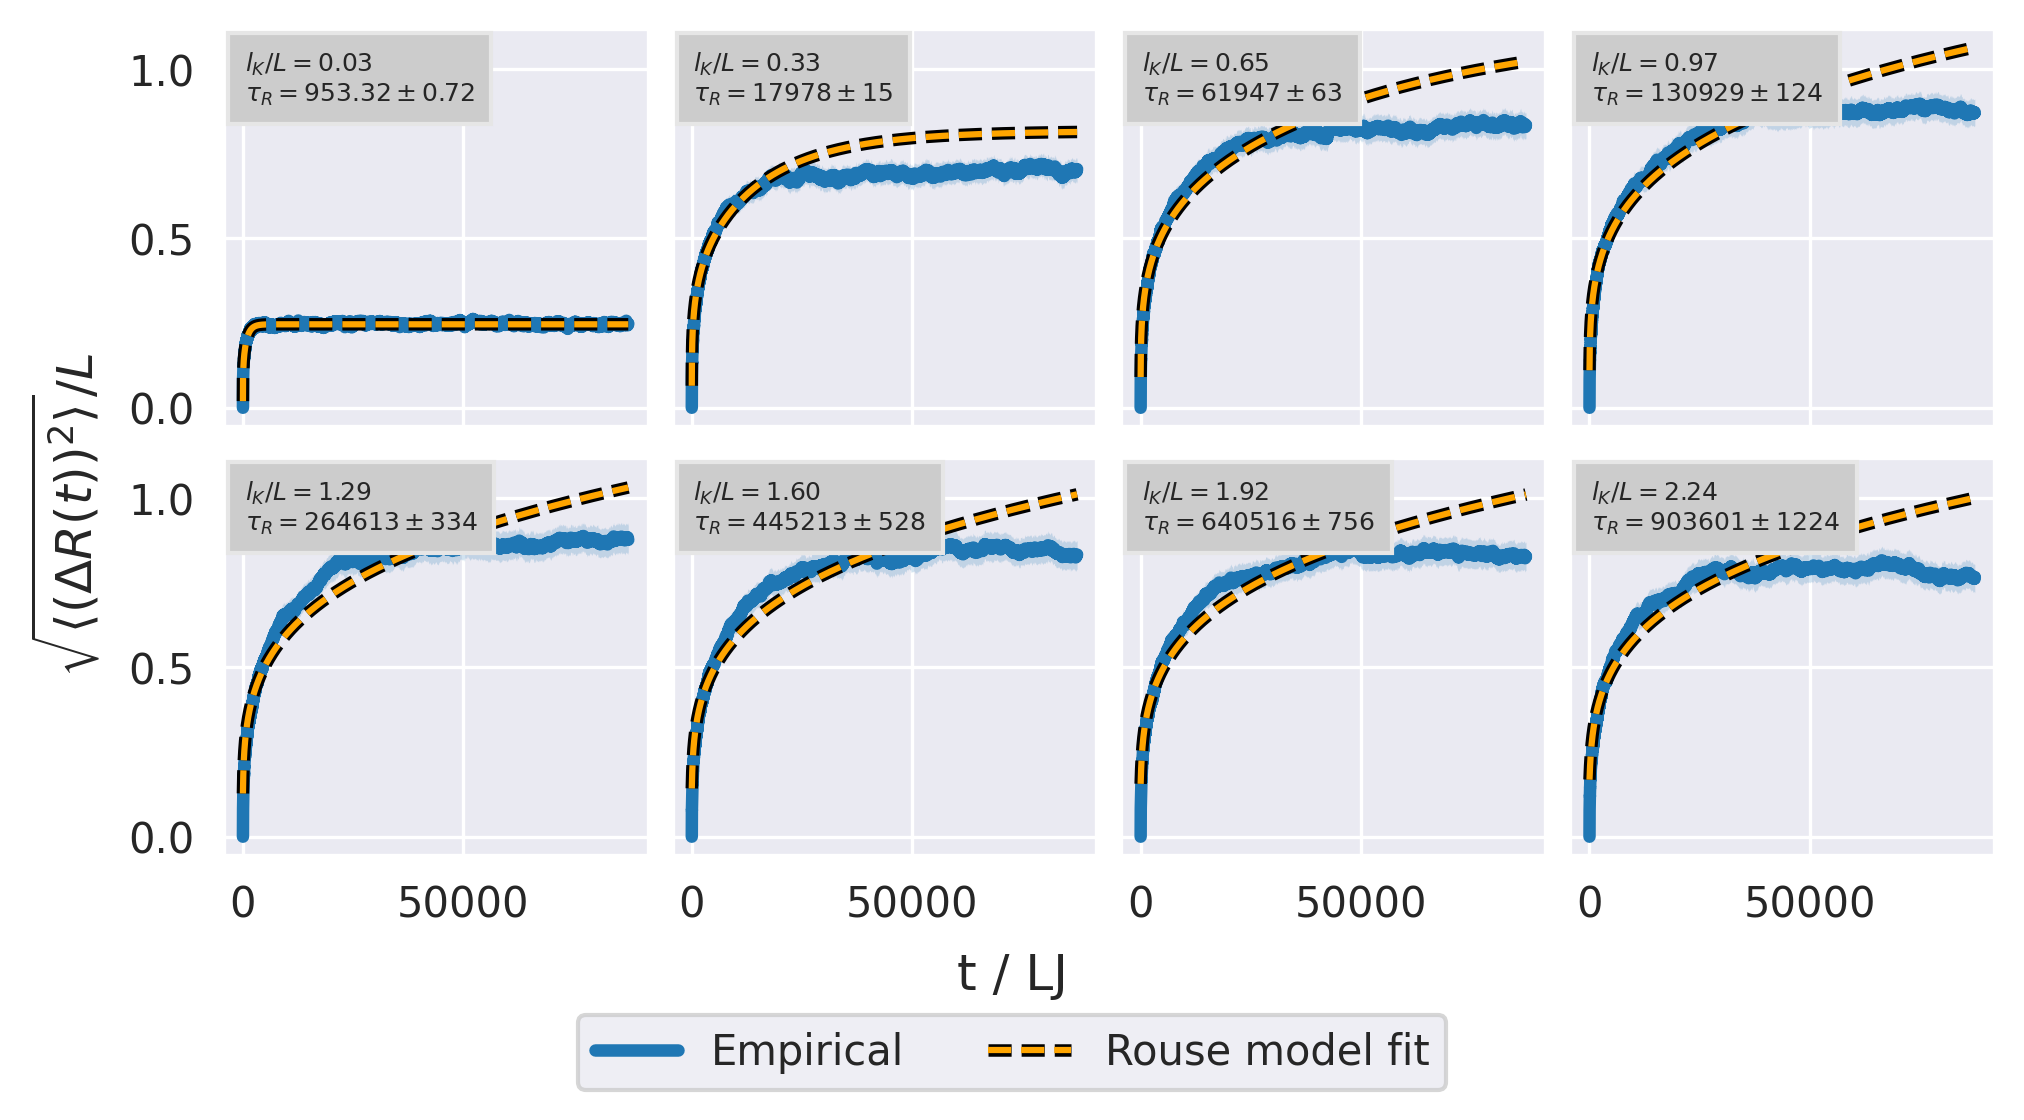

In [47]:
fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=plot_utils.get_figure_size(width=1.0, n_rows=2, n_cols=4, height=0.5), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()

for i, (kappa, df_g) in enumerate(df_msd.groupby("kappa")):

    ax = axs[i]
    l_K = kremer_grest.bare_kuhn_length(kappa, l_b)
    y = np.sqrt(df_g[f"dR^2"]) / L_contour
    dy = df_g[f"delta dR^2"] / (np.sqrt(df_g[f"dR^2"]) * L_contour * 2)

    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    if dtau_R >= 1.0:
        tau_R = round(tau_R)
        dtau_R = round(dtau_R)
        tau_label = f"$\\tau_R = {tau_R} \pm {dtau_R}$"
    else:
        tau_label = f"$\\tau_R = {tau_R:.2f} \pm {dtau_R:.2f}$"

    label = f"$l_K / L = {l_K / L_contour : .2f}$\n{tau_label}"
    trans = matplotlib.transforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)

    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=6, verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='0.9'))

    ax.plot(
        df_g["t/LJ"],
        y,
        label="Empirical",
        linewidth=3
    )

    ax.fill_between(
        x=df_g["t/LJ"],
        y1=y - dy,
        y2=y + dy,
        alpha=.2,
        linewidth=0
    )

    rouse_fit = rouse.rouse_g_4(
        t=df_g["t/LJ"],
        N_b=N_K,
        l_b=l_K,
        p_max=conf.initial_system_config.system_config.n_monomers,
        tau_R=tau_R
    )

    ax.plot(
        df_g["t/LJ"],
        np.sqrt(rouse_fit) / L_contour,
        label=f"Rouse model fit",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()],
        color="orange",
        linestyle="--"
    )

    ax.legend().set_visible(False)

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
#fig.suptitle(
#    f"MSD: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; $\zeta_e = \zeta = 1.0$; L={L_contour : .2f}")

### Adjusted rouse model: Fit $\tau_R$, $a$

In [48]:
df_rouse_times_fit = []

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_msd.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    #p_max = int(round(N_K)) if N_K > 1 else 1
    p_max = 1
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4_adj, p_max=p_max, R=df_kuhn_summary.loc[kappa]["R^2"], b=1),
        df_ete_change_kappas_equi_kappa["t/LJ"],
        df_ete_change_kappas_equi_kappa["dR^2"],
        #sigma=df_ete_change_kappas_equi_kappa["delta dR^2"].iloc[1:],
        #absolute_sigma=True,
        maxfev=2000,
        p0=(df_rouse_times_theory.loc[kappa]["Theory tau_R"], 2),
        bounds=([0, 0], [np.inf, np.inf])
    )
    df_rouse_times_fit.append((kappa, popt[0], np.sqrt(np.diag(pcov))[0], l_K, N_K, popt[1], np.sqrt(np.diag(pcov))[1], 1))

df_rouse_times_fit = pd.DataFrame(
    df_rouse_times_fit,
    columns=["kappa", "Empirical tau_R", "Empirical Delta tau_R", "l_K", "N_K", "a", "delta a","b"]
).set_index("kappa")

df_rouse_times_fit["Empirical tau_0"] = df_rouse_times_fit["Empirical tau_R"] / df_rouse_times_fit["N_K"] ** 2
df_rouse_times_fit["Empirical Delta tau_0"] = df_rouse_times_fit["Empirical Delta tau_R"] / df_rouse_times_fit[
    "N_K"] ** 2

df_rouse_times_fit

Empirical tau_R  Empirical Delta tau_R         l_K        N_K  \
kappa                                                                  
1.0         768.514273               1.141724    1.854017  32.960864   
11.0       5664.140201               6.077726   20.370000   3.000000   
21.0       8449.287489               9.230514   39.770000   1.536585   
31.0       9549.060213              13.127675   59.170000   1.032787   
41.0      10090.455644               9.636525   78.570000   0.777778   
51.0       9859.426103              10.241859   97.970000   0.623762   
61.0       9667.267729              10.427191  117.370000   0.520661   
71.0       8604.676571               7.976968  136.770000   0.446809   

              a   delta a  b  Empirical tau_0  Empirical Delta tau_0  
kappa                                                                 
1.0    1.993612  0.000600  1         0.707383               0.001051  
11.0   1.685381  0.000912  1       629.348919               0.675303  
21.0   1.456440  0.000772  1      3578.546805               3.909421  
31.0   1.333883  0.000870  1      8952.394319              12.307402  
41.0   1.164767  0.000522  1     16680.140963              15.929766  
51.0   1.004755  0.000492  1     25340.389437              26.323307  
61.0   0.943176  0.000481  1     35660.989372              38.464224  
71.0   0.809243  0.000363  1     43101.429808              39.957191

Text(0.02, 0.5, '$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$')

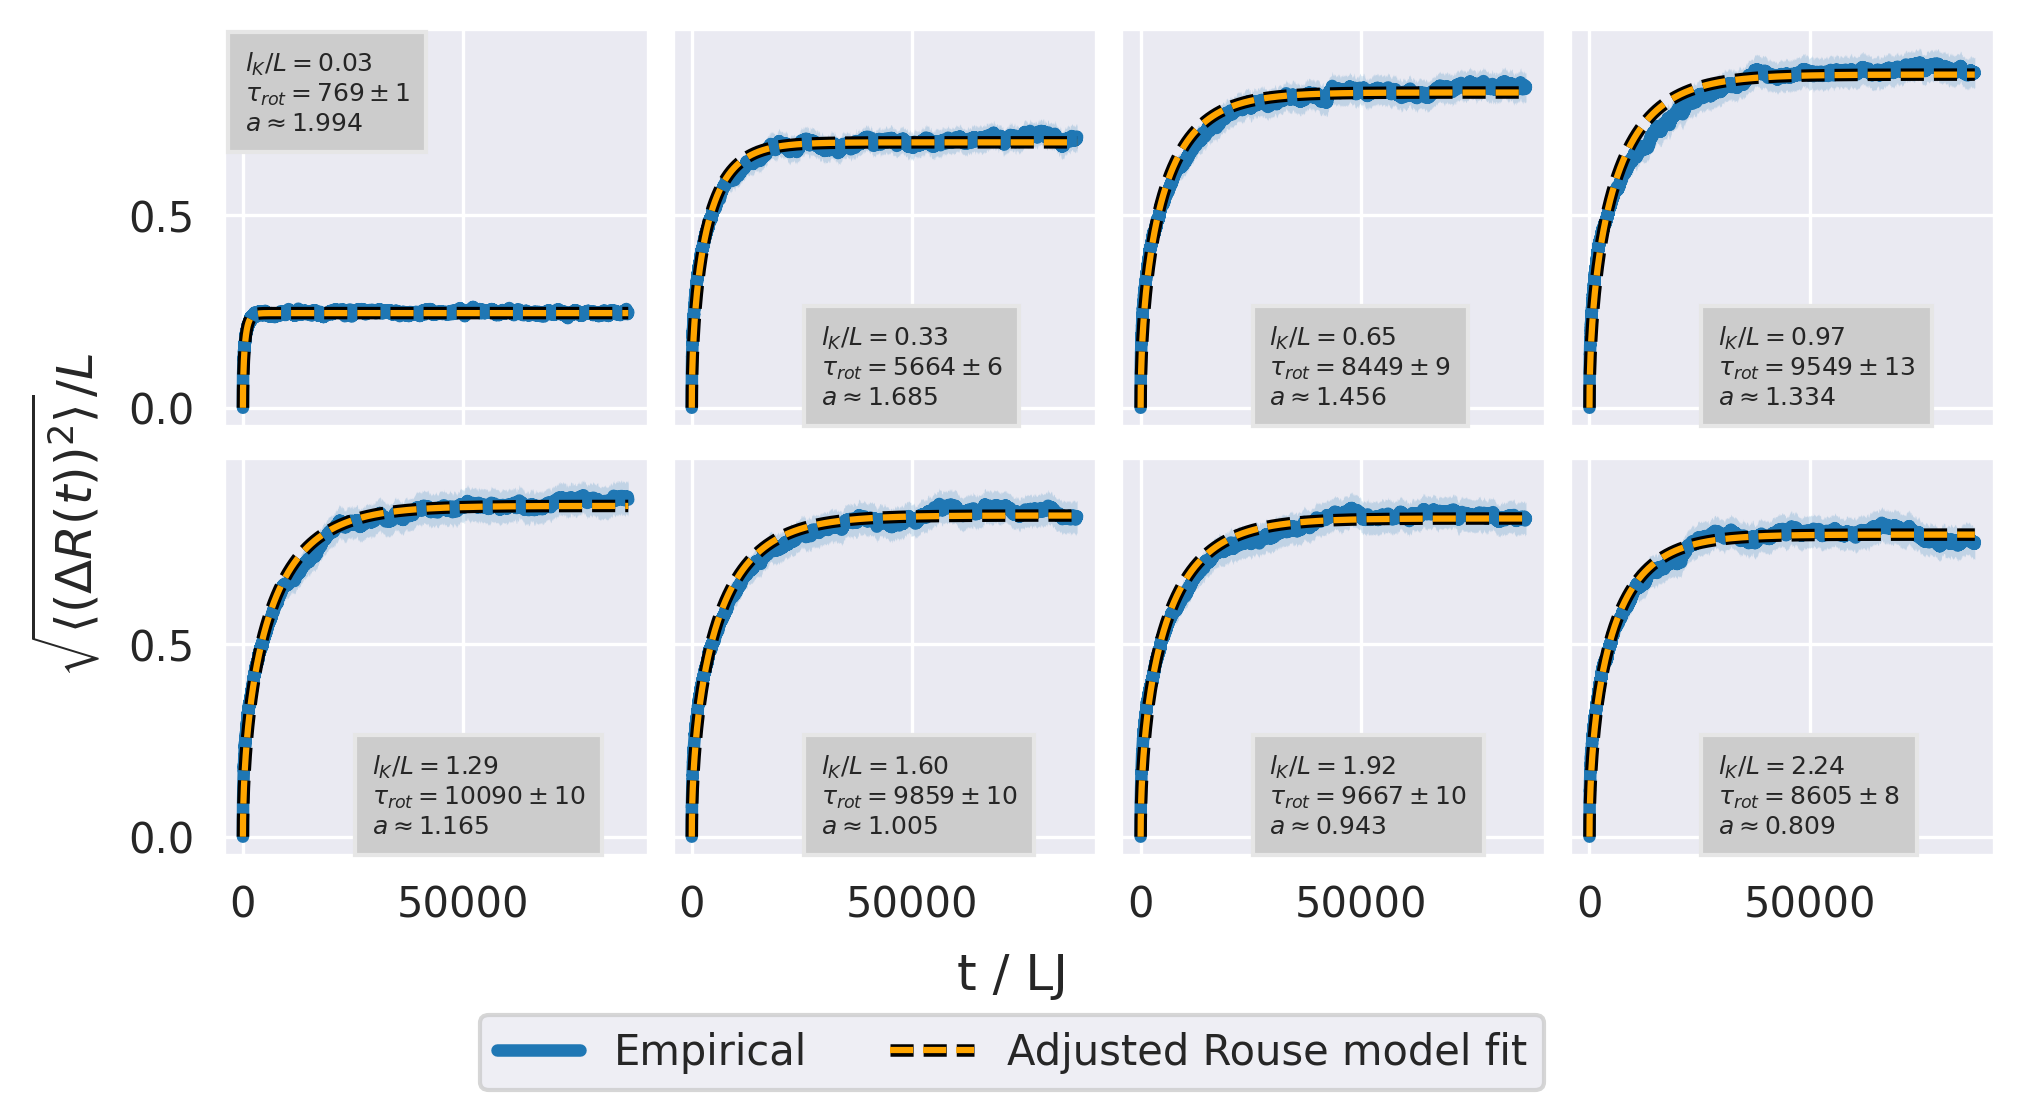

In [49]:
fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=plot_utils.get_figure_size(width=1.0, n_rows=2, n_cols=4, height=0.5), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()

for i, (kappa, df_g) in enumerate(df_msd.groupby("kappa")):

    ax = axs[i]
    l_K = kremer_grest.bare_kuhn_length(kappa, l_b)
    y = np.sqrt(df_g[f"dR^2"]) / L_contour
    dy = df_g[f"delta dR^2"] / (np.sqrt(df_g[f"dR^2"]) * L_contour * 2)

    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    if dtau_R >= 1.0:
        tau_R = round(tau_R)
        dtau_R = round(dtau_R)
        tau_label = f"$\\tau_{{rot}} = {tau_R} \pm {dtau_R}$"
    else:
        tau_label = f"$\\tau_{{rot}} = {tau_R:.2f} \pm {dtau_R:.2f}$"


    a = df_rouse_times_fit.loc[kappa]["a"]
    da = df_rouse_times_fit.loc[kappa]["delta a"]
    a_label = f"$a \\approx {a:.3f}$"

    label = f"$l_K / L = {l_K / L_contour : .2f}$\n{tau_label}\n{a_label}"
    trans = matplotlib.transforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)

    if i == 0:
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize=6, verticalalignment='top',
                bbox=dict(facecolor='0.8', edgecolor='0.9'))
    else:
        ax.text(0.3, 0.31, label, transform=ax.transAxes + trans,
                fontsize=6, verticalalignment='top',
                bbox=dict(facecolor='0.8', edgecolor='0.9'))

    ax.plot(
        df_g["t/LJ"],
        y,
        label="Empirical",
        linewidth=3
    )

    ax.fill_between(
        x=df_g["t/LJ"],
        y1=y - dy,
        y2=y + dy,
        alpha=.2,
        linewidth=0
    )

    rouse_fit = rouse.rouse_g_4_adj(
        t=df_g["t/LJ"],
        R=df_kuhn_summary.loc[kappa]["R^2"],
        p_max=1,
        tau_R=tau_R,
        a=df_rouse_times_fit.loc[kappa]["a"],
        b=df_rouse_times_fit.loc[kappa]["b"]
    )

    ax.plot(
        df_g["t/LJ"],
        np.sqrt(rouse_fit) / L_contour,
        label=f"Adjusted Rouse model fit",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()],
        color="orange",
        linestyle="--"
    )

    ax.legend().set_visible(False)

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
#fig.suptitle(
#    f"MSD: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; $\zeta_e = \zeta = 1.0$; L={L_contour : .2f}")

Text(0.02, 0.5, '$ \\sqrt {{\\langle (\\Delta R(t))^2 \\rangle}} / L$')

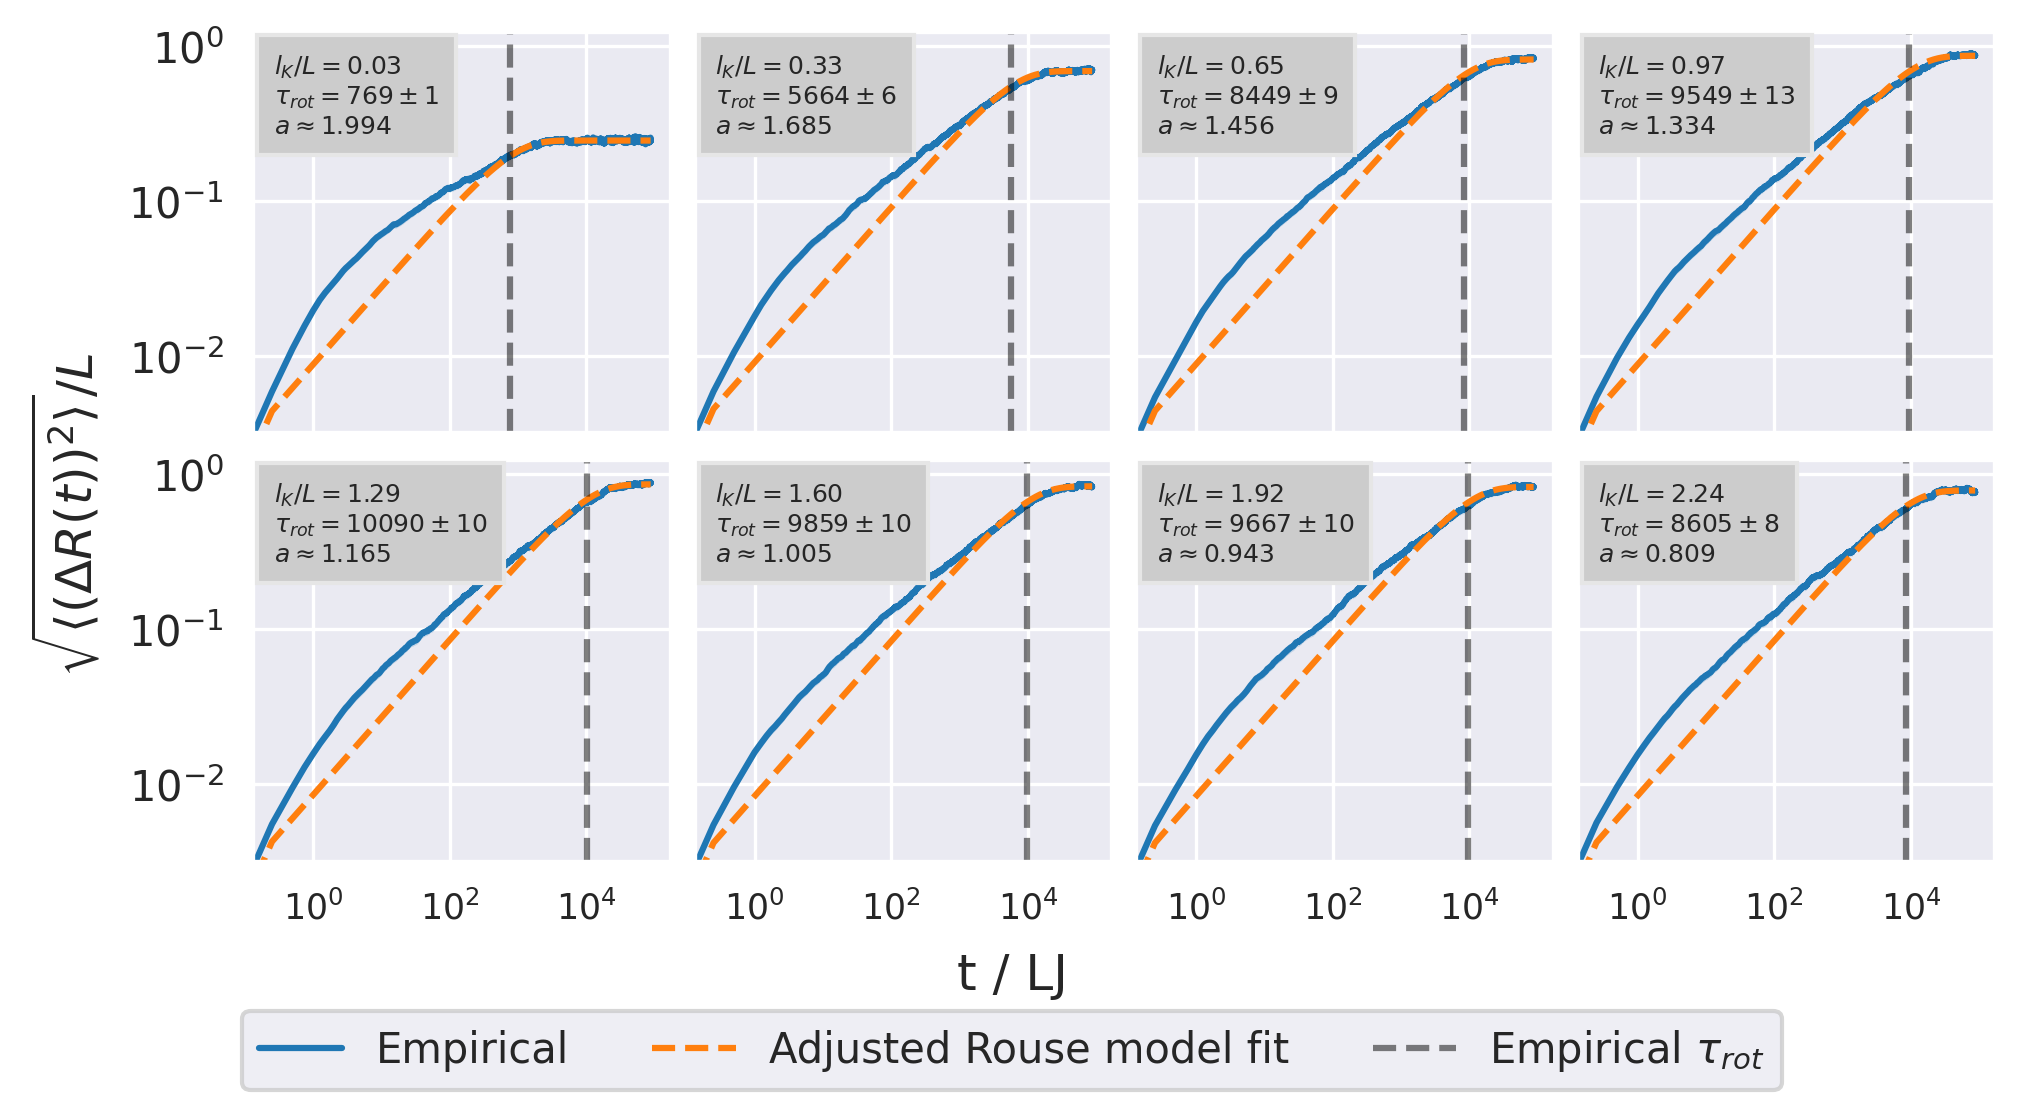

In [50]:
fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=plot_utils.get_figure_size(width=1.0, n_rows=2, n_cols=4, height=0.5), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()

for i, (kappa, df_g) in enumerate(df_msd.groupby("kappa")):

    ax = axs[i]

    l_K = kremer_grest.bare_kuhn_length(kappa, l_b)
    y = np.sqrt(df_g[f"dR^2"]) / L_contour
    dy = df_g[f"delta dR^2"] / (np.sqrt(df_g[f"dR^2"]) * L_contour * 2)

    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    if dtau_R >= 1.0:
        tau_R = round(tau_R)
        dtau_R = round(dtau_R)
        tau_label = f"$\\tau_{{rot}} = {tau_R} \pm {dtau_R}$"
    else:
        tau_label = f"$\\tau_{{rot}} = {tau_R:.2f} \pm {dtau_R:.2f}$"


    a = df_rouse_times_fit.loc[kappa]["a"]
    da = df_rouse_times_fit.loc[kappa]["delta a"]
    a_label = f"$a \\approx {a:.3f}$"

    label = f"$l_K / L = {l_K / L_contour : .2f}$\n{tau_label}\n{a_label}"
    trans = matplotlib.transforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)

    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize=6, verticalalignment='top',
                bbox=dict(facecolor='0.8', edgecolor='0.9'))

    ax.plot(
        df_g["t/LJ"],
        y,
        label="Empirical",
    )

    ax.fill_between(
        x=df_g["t/LJ"],
        y1=y - dy,
        y2=y + dy,
        alpha=.2,
        linewidth=0
    )

    rouse_fit = rouse.rouse_g_4_adj(
        t=df_g["t/LJ"],
        R=df_kuhn_summary.loc[kappa]["R^2"],
        p_max=1,
        tau_R=tau_R,
        a=df_rouse_times_fit.loc[kappa]["a"],
        b=df_rouse_times_fit.loc[kappa]["b"]
    )


    ax.plot(
        df_g["t/LJ"],
        np.sqrt(rouse_fit) / L_contour,
        label=f"Adjusted Rouse model fit",
        color=sns.color_palette()[1],
        linestyle="--"
    )
    
    l_p = l_K / 2
    
    
    ax.axvline(tau_R, color="black", alpha=0.5, linestyle="--", label="Empirical $\\tau_{{rot}}$")
    
    ax.legend().set_visible(False)

    ax.set(xscale="log", yscale="log")  
    ax.set_xticks([1, 1e2, 1e4])
    ax.tick_params(axis="x", labelsize="small")
    
fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
#fig.suptitle(
 #   f"MSD: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; $\zeta_e = \zeta = 1.0$; L={L_contour : .2f}")

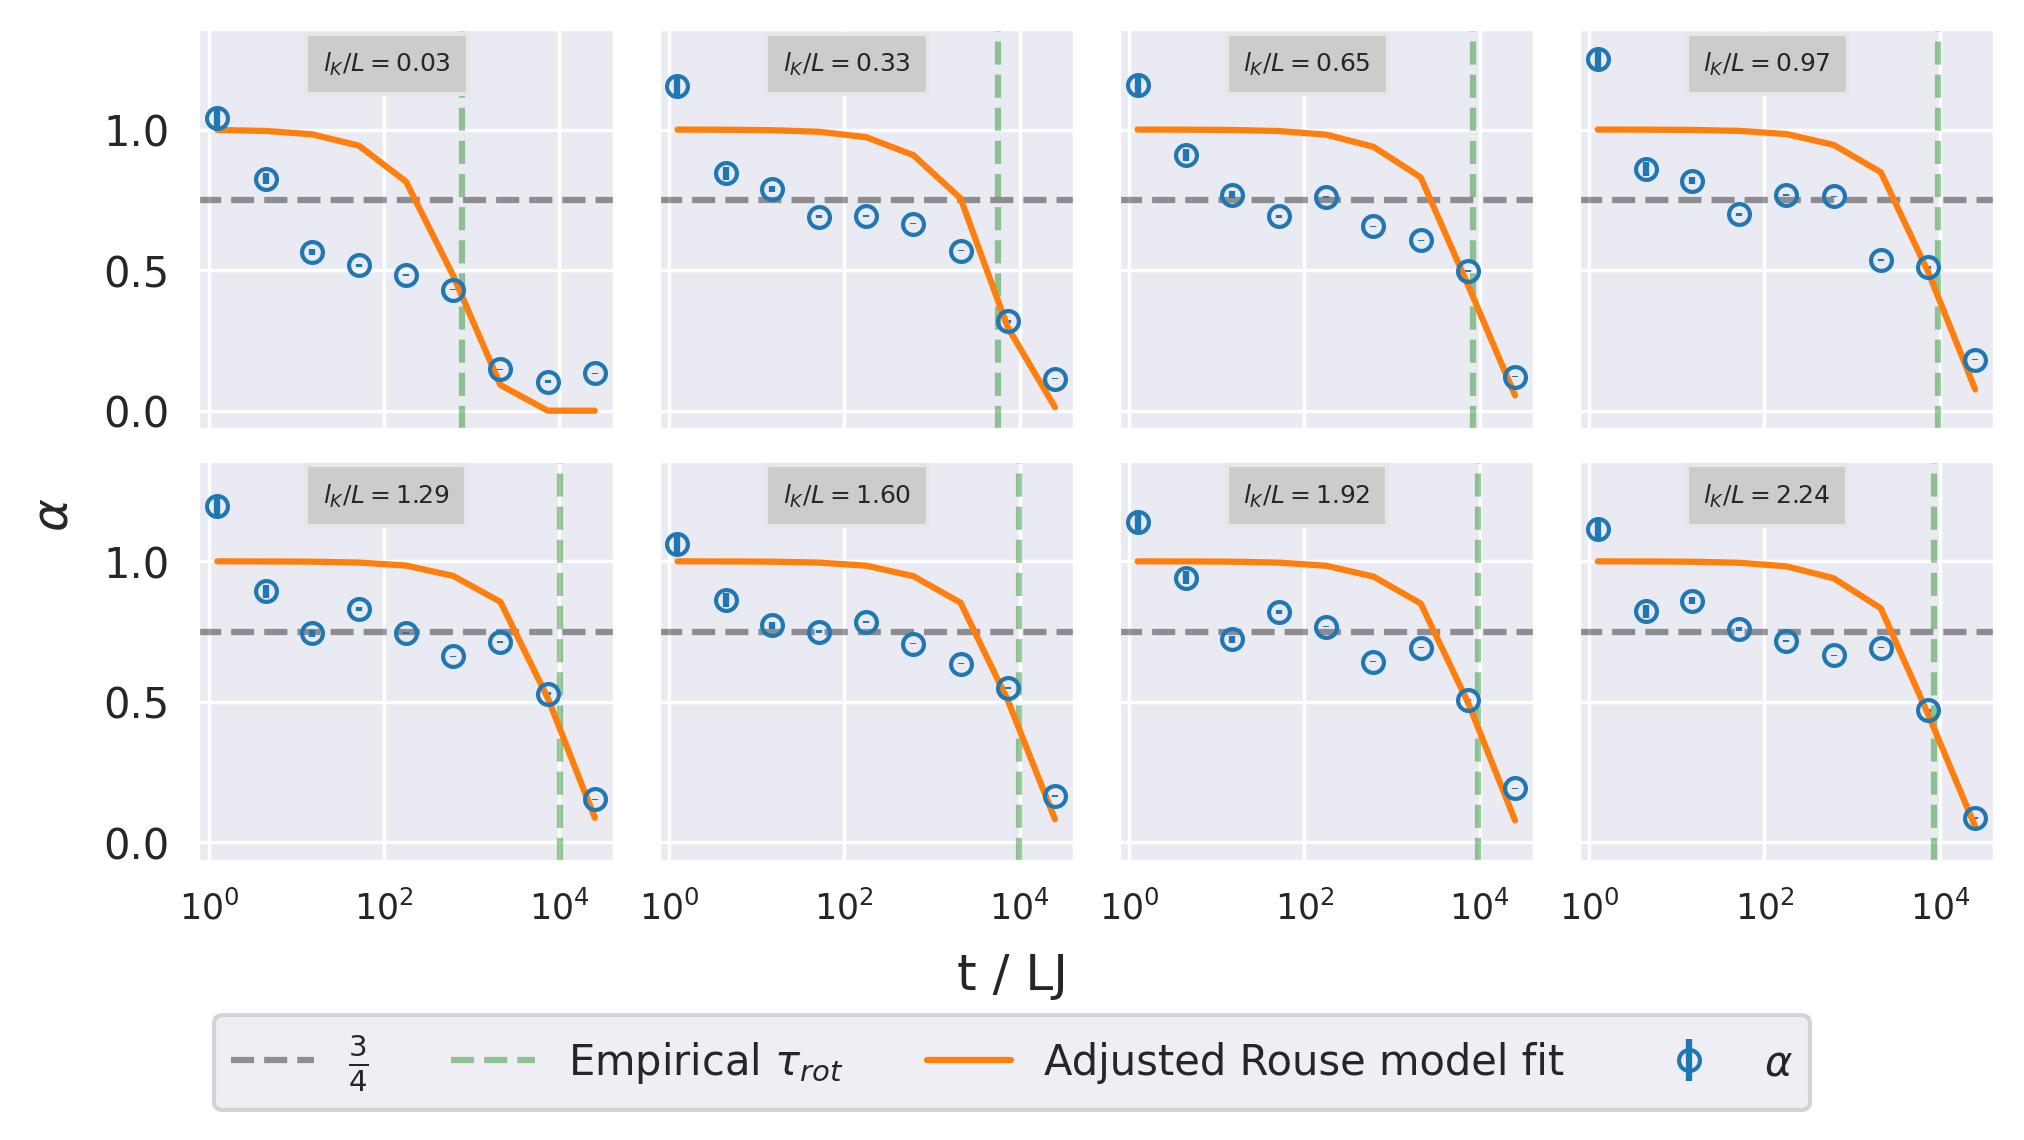

In [65]:
import polyflexmd.data_analysis.transform.msdlm

fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=plot_utils.get_figure_size(width=1.0, n_rows=2, n_cols=4, height=0.5), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()

color = sns.color_palette()[0]

for i, (kappa, df_g) in enumerate(df_msd.groupby("kappa")):
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    l_K = df_rouse_times_fit.loc[kappa]["l_K"]
    alpha_df = polyflexmd.data_analysis.transform.msdlm.calculate_msd_alpha_df(df_g.loc[df_g["t/LJ"] > 1], n_bins=10, col="dR^2")
    ax = axs[i]
    ax.axhline(y=3/4, color="black", alpha=0.4, linestyle = "--", label="$\\frac{3}{4}$")
    ax.axvline(tau_R, alpha=0.4, linestyle = "--", color="green", label="Empirical $\\tau_{{rot}}$")
    plot_kwargs = {}
    plot_kwargs["linestyle"] = 'None'
    plot_kwargs["markersize"] = 5
    plot_kwargs["markerfacecolor"] = 'none'
    plot_kwargs["markeredgecolor"] = sns.color_palette()[0]
    plot_kwargs["markeredgewidth"] = 1.0
    plot_kwargs["fillstyle"] = 'none'
    plot_kwargs["marker"] = "o"
    
    ax.errorbar(
        alpha_df.index, 
        y=alpha_df["alpha"], 
        yerr=alpha_df["delta alpha"], 
        color=sns.color_palette()[0],
        label="$\\alpha$",
        **plot_kwargs
    )
    
    
    msd_adj = rouse.rouse_g_4_adj(
        t=df_g["t/LJ"],
        R=df_kuhn_summary.loc[kappa]["R^2"],
        p_max=1,
        tau_R=tau_R,
        a=df_rouse_times_fit.loc[kappa]["a"],
        b=df_rouse_times_fit.loc[kappa]["b"]
    )
    df_adj = df_g.copy()
    df_adj["dR^2"] = msd_adj
    alpha_adj = polyflexmd.data_analysis.transform.msdlm.calculate_msd_alpha_df(df_adj.loc[df_adj["t/LJ"] > 1], n_bins=10, col="dR^2")
    
    
    
    #ax.plot(alpha_df.index, alpha_df["alpha"], alpha=0.1, color=sns.color_palette()[0])
    ax.plot(alpha_adj.index, alpha_adj["alpha"], alpha=1, color=sns.color_palette()[1], label="Adjusted Rouse model fit")
    ax.legend().set_visible(False)
    ax.set(xscale="log")
    
    trans = matplotlib.transforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)
    
    label = f"$l_K / L = {l_K / L_contour : .2f}$"
    
    ax.text(0.25, 1.0, label, transform=ax.transAxes + trans,
                fontsize=6, verticalalignment='top',
                bbox=dict(facecolor='0.8', edgecolor='0.9'))
    
    ax.set_xticks([1, 1e2, 1e4])
    ax.tick_params(axis="x", labelsize="small")
    
fig.supxlabel("t / LJ")
fig.supylabel("$\\alpha$")
fig.legend(*axs[-1].get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.12))

Experiment: $l_K/L=0.03$: 100%|██████████| 23296/23296 [00:17<00:00, 1346.41it/s]


t/LJ     alpha  delta alpha    delta t           interval   count
0            NaN       NaN          NaN        NaN                NaN     NaN
1            NaN       NaN          NaN        NaN                NaN     NaN
2          1.500  1.138883     0.289384      0.250       (1.25, 1.75)     3.0
3          1.625  1.112075     0.181537      0.375        (1.25, 2.0)     4.0
4          1.750  1.097413     0.129040      0.500       (1.25, 2.25)     5.0
...          ...       ...          ...        ...                ...     ...
23291  48075.000  0.068233     0.001168  39325.000  (8750.0, 87400.0)  3147.0
23292  48087.500  0.068219     0.001168  39337.500  (8750.0, 87425.0)  3148.0
23293  48100.000  0.068206     0.001167  39350.000  (8750.0, 87450.0)  3149.0
23294  48112.500  0.068195     0.001167  39362.500  (8750.0, 87475.0)  3150.0
23295  48137.500  0.068282     0.001169  39362.500  (8775.0, 87500.0)  3150.0

[23296 rows x 6 columns]

Experiment: $l_K/L=0.33$: 100%|██████████| 23296/23296 [00:18<00:00, 1289.68it/s]


t/LJ     alpha  delta alpha    delta t           interval   count
0            NaN       NaN          NaN        NaN                NaN     NaN
1            NaN       NaN          NaN        NaN                NaN     NaN
2          1.500  1.287279     0.312145      0.250       (1.25, 1.75)     3.0
3          1.625  1.272514     0.198988      0.375        (1.25, 2.0)     4.0
4          1.750  1.257756     0.143795      0.500       (1.25, 2.25)     5.0
...          ...       ...          ...        ...                ...     ...
23291  48075.000  0.181473     0.001025  39325.000  (8750.0, 87400.0)  3147.0
23292  48087.500  0.181455     0.001024  39337.500  (8750.0, 87425.0)  3148.0
23293  48100.000  0.181438     0.001024  39350.000  (8750.0, 87450.0)  3149.0
23294  48112.500  0.181423     0.001024  39362.500  (8750.0, 87475.0)  3150.0
23295  48137.500  0.181678     0.001025  39362.500  (8775.0, 87500.0)  3150.0

[23296 rows x 6 columns]

Experiment: $l_K/L=0.65$: 100%|██████████| 23296/23296 [00:18<00:00, 1291.74it/s]


t/LJ     alpha  delta alpha    delta t           interval   count
0            NaN       NaN          NaN        NaN                NaN     NaN
1            NaN       NaN          NaN        NaN                NaN     NaN
2          1.500  1.246338     0.296325      0.250       (1.25, 1.75)     3.0
3          1.625  1.252192     0.185906      0.375        (1.25, 2.0)     4.0
4          1.750  1.250052     0.135398      0.500       (1.25, 2.25)     5.0
...          ...       ...          ...        ...                ...     ...
23291  48075.000  0.301758     0.000993  39325.000  (8750.0, 87400.0)  3147.0
23292  48087.500  0.301726     0.000993  39337.500  (8750.0, 87425.0)  3148.0
23293  48100.000  0.301695     0.000993  39350.000  (8750.0, 87450.0)  3149.0
23294  48112.500  0.301664     0.000992  39362.500  (8750.0, 87475.0)  3150.0
23295  48137.500  0.302090     0.000994  39362.500  (8775.0, 87500.0)  3150.0

[23296 rows x 6 columns]

Experiment: $l_K/L=0.97$: 100%|██████████| 23296/23296 [00:17<00:00, 1322.76it/s]


t/LJ     alpha  delta alpha    delta t           interval   count
0            NaN       NaN          NaN        NaN                NaN     NaN
1            NaN       NaN          NaN        NaN                NaN     NaN
2          1.500  1.340125     0.316445      0.250       (1.25, 1.75)     3.0
3          1.625  1.352315     0.198710      0.375        (1.25, 2.0)     4.0
4          1.750  1.341065     0.141292      0.500       (1.25, 2.25)     5.0
...          ...       ...          ...        ...                ...     ...
23291  48075.000  0.351100     0.000986  39325.000  (8750.0, 87400.0)  3147.0
23292  48087.500  0.351059     0.000986  39337.500  (8750.0, 87425.0)  3148.0
23293  48100.000  0.351018     0.000986  39350.000  (8750.0, 87450.0)  3149.0
23294  48112.500  0.350977     0.000985  39362.500  (8750.0, 87475.0)  3150.0
23295  48137.500  0.351468     0.000987  39362.500  (8775.0, 87500.0)  3150.0

[23296 rows x 6 columns]

$\zeta_e$   $l_K/L$  $\tau_1$ $\tau_b$ $\tau_0$  $\alpha_{min}$  \
0        1.0  0.030339      0.82    11.00     0.94           0.055   
1        1.0  0.333333   1089.21    11.00     0.94           0.180   
2        1.0  0.650794   8105.97    11.00     0.94           0.301   
3        1.0  0.968254  26695.80    11.00     0.94           0.351   

   $\Delta \alpha_{min}$  $\alpha_{ref}$  
0                  0.002        0.666667  
1                  0.001        0.666667  
2                  0.001        0.666667  
3                  0.001        0.666667

\begin{tabular}{rrlllrrr}
\toprule
$\zeta_e$ & $l_K/L$ & $\tau_1$ & $\tau_b$ & $\tau_0$ & $\alpha_{min}$ & $\Delta \alpha_{min}$ & $\alpha_{ref}$ \\
\midrule
1.000000 & 0.030339 & 0.82 & 11.00 & 0.94 & 0.055000 & 0.002000 & 0.666667 \\
1.000000 & 0.333333 & 1089.21 & 11.00 & 0.94 & 0.180000 & 0.001000 & 0.666667 \\
1.000000 & 0.650794 & 8105.97 & 11.00 & 0.94 & 0.301000 & 0.001000 & 0.666667 \\
1.000000 & 0.968254 & 26695.80 & 11.00 & 0.94 & 0.351000 & 0.001000 & 0.666667 \\
\bottomrule
\end{tabular}


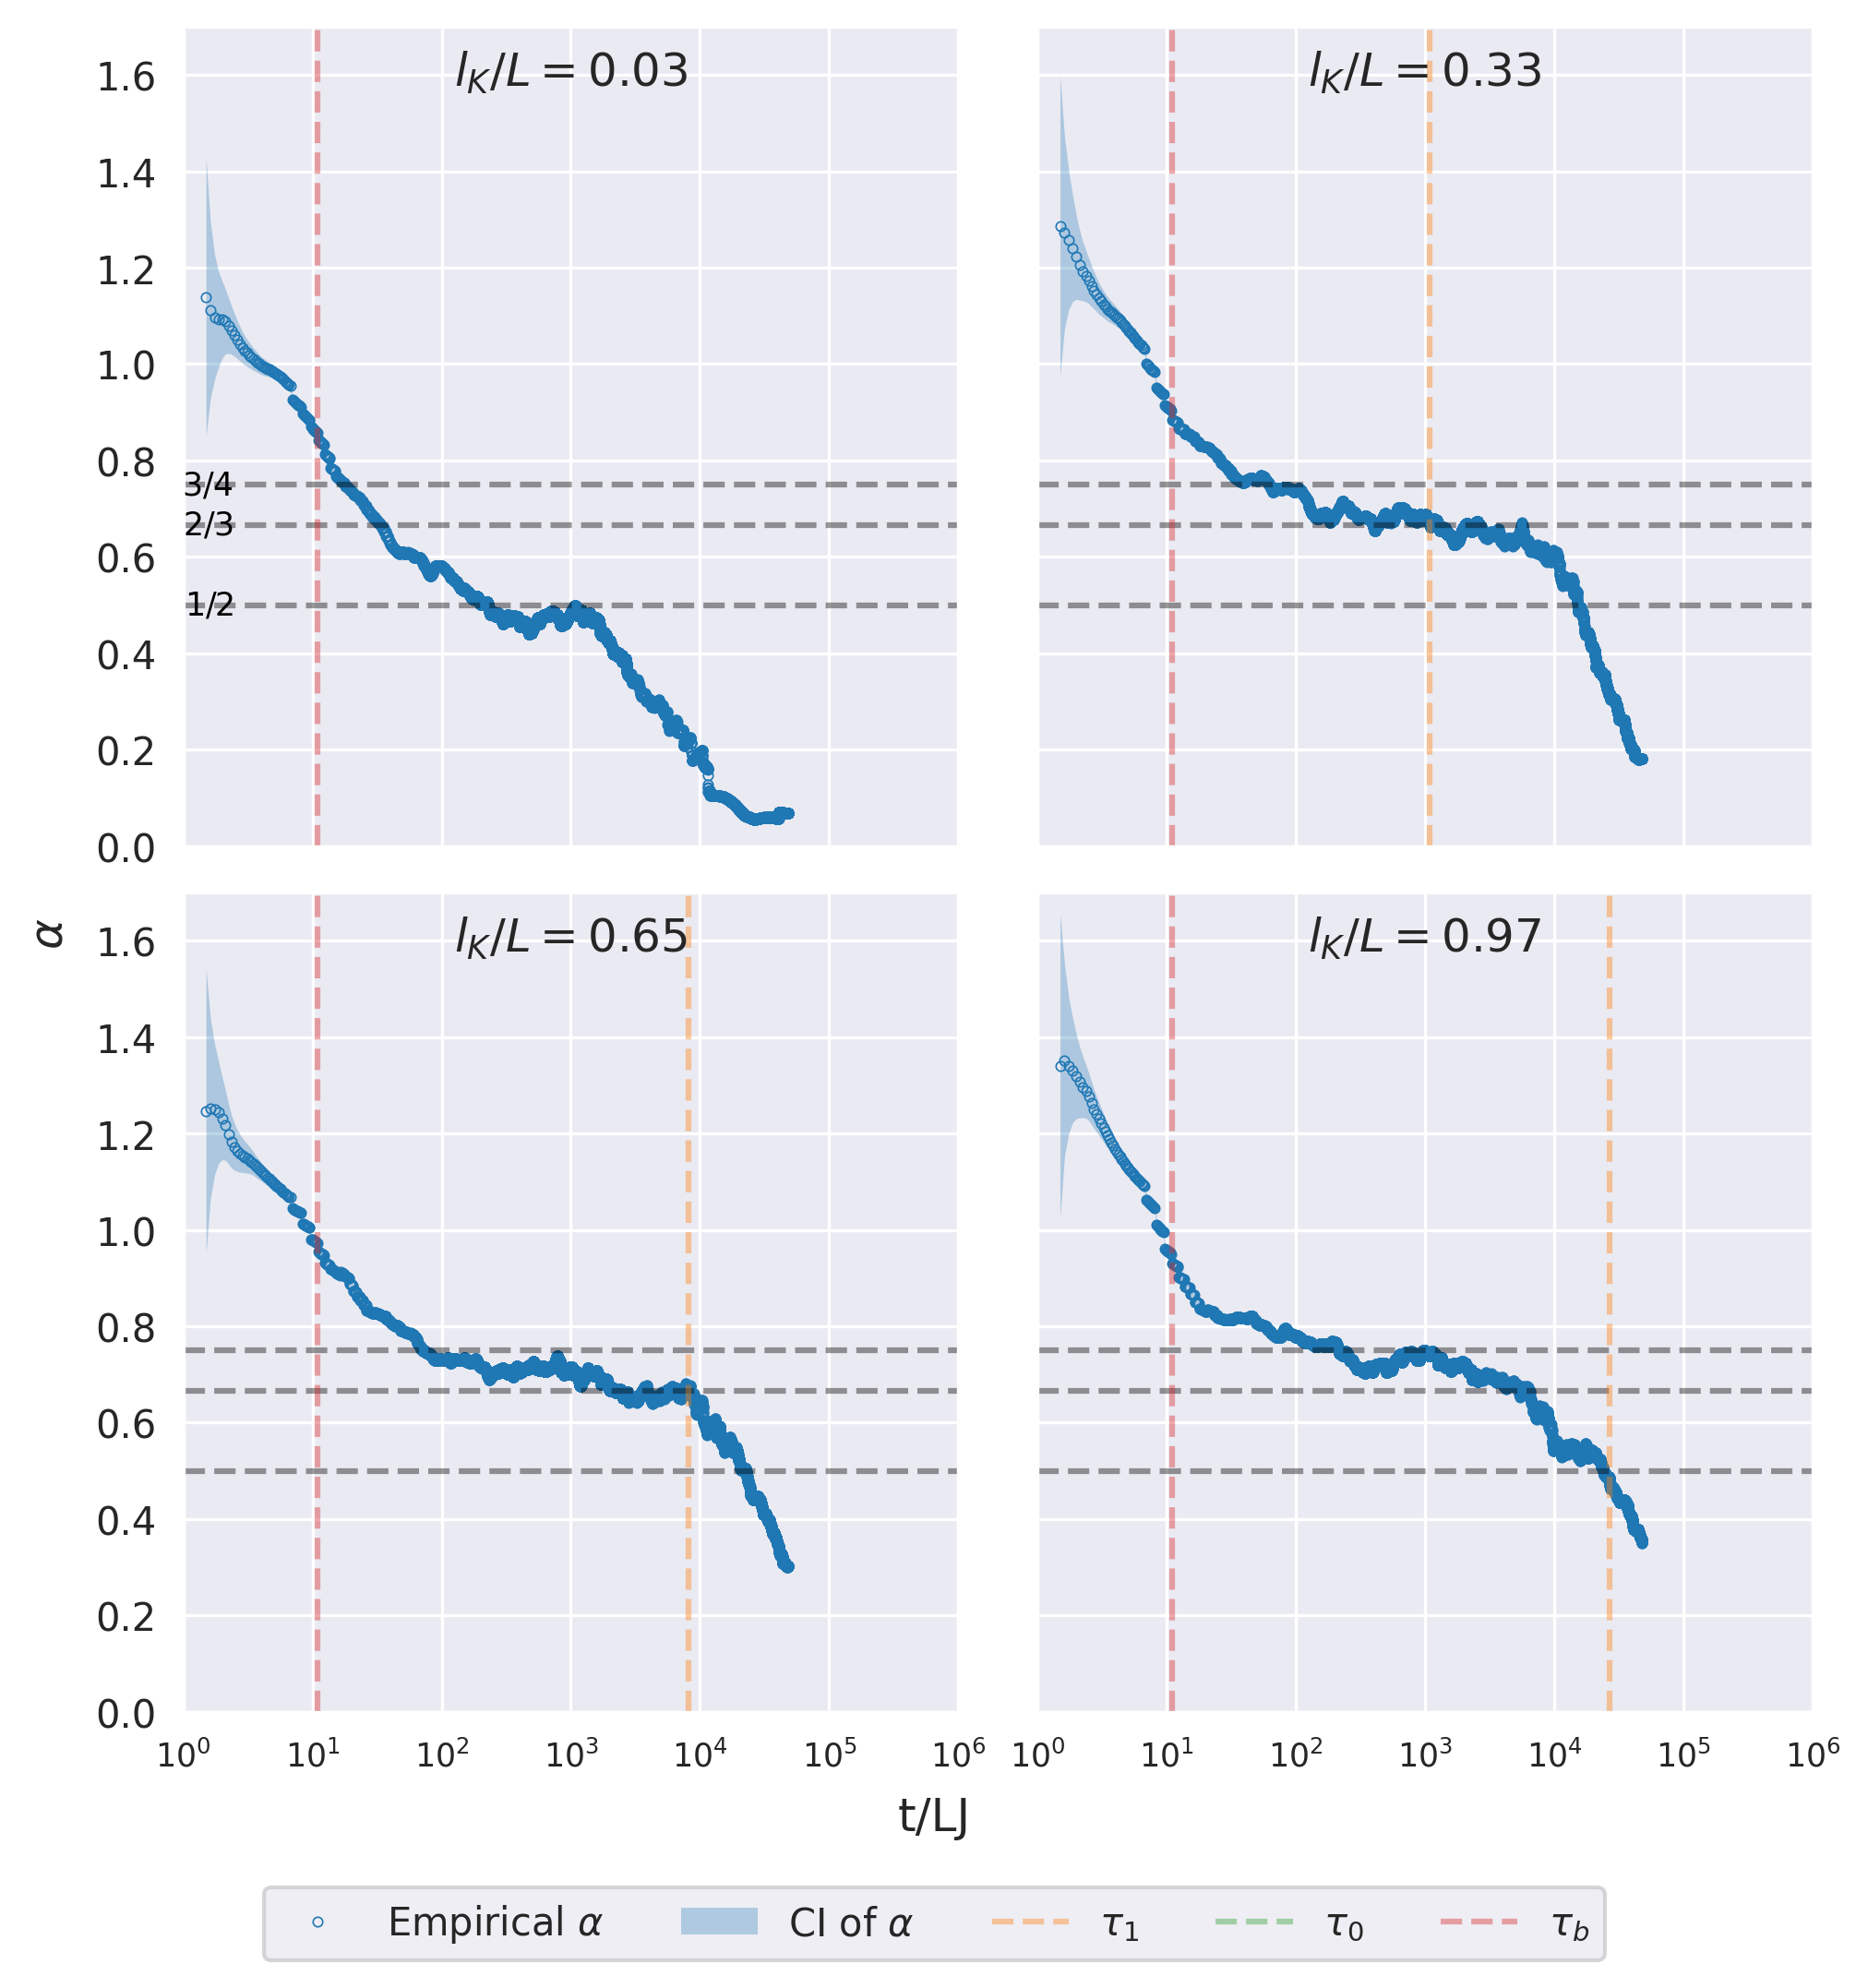

In [59]:
import matplotlib.transforms as transforms

from scipy.optimize import curve_fit
import multiprocessing.pool
import tqdm

def tau_1_rod_limit(tau_0: float, L: float, l_p: float, l_b: float) -> float:
    return tau_0 * L ** 4 / (l_p * l_b ** 3)


def tau_1_coil_limit(tau_0: float, l_p: float, l_b: float) -> float:
    return tau_0 * (l_p / l_b) ** 3


def linregbin(df):
    col = "dR^2"
    if len(df) < 3:
        return pd.Series([np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN], index=["t/LJ", "alpha", "delta alpha", "delta t", "interval", "count"])
    f = lambda x, k: k * x
    xs = np.log10(df["t/LJ"])
    ys = np.log10(df[col])
    xs = xs - xs.min()
    ys = ys - ys.min()
    if f"delta {col}" in df.columns:
        dr = df[col]
        sigma_dr = df[f"delta {col}"] / 3
        dys = np.abs(1 / (dr * np.log(10)) * sigma_dr)
        popt, pcov = curve_fit(f, xs, ys, p0=(0.0), sigma=dys, absolute_sigma=True)
    else:
        popt, pcov = curve_fit(f, xs, ys, p0=(0.0))
    delta_alpha = np.sqrt(np.diag(pcov)[0]) * 3
    t_min = df["t/LJ"].min()
    t_max = df["t/LJ"].max()
    delta_t = (t_max - t_min) / 2
    t = t_min + delta_t
    return pd.Series(
        [t, popt[0], delta_alpha, delta_t, (t_min, t_max), df.shape[0]],
        index=["t/LJ", "alpha", "delta alpha", "delta t", "interval", "count"]
    )

def estimate_alpha(
        experiments: list[dict],
        scatter: bool = False,
        markersize: float = 5.0,
        markeredgewidth: float = 0.4,
        log_window_size: float = 1,
        calculate_alpha: bool = True,
        t_end: float = 1e6,
        nrows=2,
        ncols=2,
        legend_y_margin=-0.07,
):
    
    ax: plt.Axes
    fig, axs = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=plot_utils.get_figure_size(
            width=1.0,
            n_rows=nrows,
            height=1 if ncols > 1 else None,
        ),
        sharex="all",
        sharey="row",
        layout="constrained"
    )
    
    if isinstance(axs, plt.Axes):
        axs = [axs]
    else:
        axs = axs.flatten()
    
    data = []
    
    for experiment, ax in zip(experiments, axs):
        
        if not "df_alpha" in experiment or calculate_alpha:
            df = experiment["df_msd"]
            df = df.loc[df["t/LJ"]<=t_end]
            # Estimate alpha
            t_like_log_index = pd.TimedeltaIndex(
                np.log10(df["t/LJ"]), 
                unit='seconds', 
                name="log10(t/LJ)"
            )
            df = df.set_index(t_like_log_index)
            rolling_window_iter = df.rolling(window=pd.Timedelta(log_window_size, unit="s"), min_periods=3)
            with multiprocessing.pool.Pool(processes=32) as p:
                results = tqdm.tqdm(
                    p.imap(linregbin, rolling_window_iter, chunksize=20), 
                    total=df.shape[0],
                    leave=True,
                    position=0,
                    desc=f"Experiment: {experiment['label']}"
                )
                experiment["df_alpha"] = pd.DataFrame(results)
                display(experiment["df_alpha"])
        
        plot_kwargs = {}
        if scatter:
            plot_kwargs["linestyle"] = 'None'
            plot_kwargs["markersize"] = markersize
            plot_kwargs["markerfacecolor"] = 'none'
            plot_kwargs["markeredgecolor"] = sns.color_palette()[0]
            plot_kwargs["markeredgewidth"] = markeredgewidth
            plot_kwargs["fillstyle"] = 'none'
            plot_kwargs["marker"] = "o"
        
        # Plot empirical
        ax.plot(
            experiment["df_alpha"]["t/LJ"],
            experiment["df_alpha"]["alpha"],
            label="Empirical $\\alpha$",
            **plot_kwargs,
        )
        ax.fill_between(
            experiment["df_alpha"]["t/LJ"],
            y1=experiment["df_alpha"]["alpha"] - experiment["df_alpha"]["delta alpha"],
            y2=experiment["df_alpha"]["alpha"] + experiment["df_alpha"]["delta alpha"],
            linewidth=0,
            color=sns.color_palette()[0],
            alpha=0.3,
            label="CI of $\\alpha$"
        )
            
        ax.set(
            xscale="log", 
            xlim=[1, t_end],
            ylim=[0, 1.7]
        )
        
        ax.set_title(label=experiment["label"], y=0.9)
        
        # Plot alpha scales
        ax.axhline(y=2 / 3, color="black", linestyle="--", alpha=0.4)
        ax.axhline(y=3 / 4, color="black", linestyle="--", alpha=0.4)
        ax.axhline(y=1 / 2, color="black", linestyle="--", alpha=0.4)
        
        # Estimate and plot time scales
        tau_0=0.97**2 * experiment["zeta_e"]
        l_p = experiment["l_K"] / 2 * L_contour 
        
        if experiment["l_K"] / 2 > 1:
            tau_1 = tau_1_rod_limit(
                tau_0 = tau_0,
                L = L_contour,
                l_p=l_p,
                l_b=0.97
            )
        else:
            tau_1 = tau_1_coil_limit(
                tau_0 = tau_0,
                l_p=l_p,
                l_b=0.97
            )
        
        experiment["tau_1"] = tau_1
        
        tau_b = experiment["m_e"] / experiment["zeta_e"]
        tau_b = tau_b + 10*tau_b
        
        ax.axvline(x=tau_1, color=sns.color_palette()[1], linestyle="--", alpha=0.4, label="$\\tau_1$")
        ax.axvline(x=tau_0, color=sns.color_palette()[2], linestyle="--", alpha=0.4, label="$\\tau_0$")
        ax.axvline(x=tau_b, color=sns.color_palette()[3], linestyle="--", alpha=0.4, label="$\\tau_b$")
        
        # Estimate alpha min
        alpha_row = experiment["df_alpha"].loc[experiment["df_alpha"]["alpha"].idxmin()]
        
        data.append({
            "$\\zeta_e$": experiment["zeta_e"],
            "$l_K/L$": experiment["l_K"],
            "$\\tau_1$": f"{experiment['tau_1']:.2f}",
            "$\\tau_b$": f"{tau_b:.2f}",
            "$\\tau_0$": f"{tau_0:.2f}",
            "$\\alpha_{min}$": np.round(alpha_row["alpha"], 3), 
            "$\\Delta \\alpha_{min}$": np.round(alpha_row["delta alpha"], 3),
            "$\\alpha_{ref}$": 3/4 if experiment["l_K"] > 1 else 2/3
        })
        
    trans = transforms.blended_transform_factory(
        axs[0].get_yticklabels()[0].get_transform(),
        axs[0].transData
    )
    
    for i in (0,):
        axs[i].text(
            0.1,
            2 / 3,
            "$2/3$",
            color="black",
            transform=trans,
            ha="right",
            va="center",
            fontsize="small"
        )
        
        axs[i].text(
            0.1,
            3 / 4,
            "$3/4$",
            color="black",
            transform=trans,
            ha="right",
            va="center",
            fontsize="small"
        )
        
        axs[i].text(
            0.1,
            1 / 2,
            "$1/2$",
            color="black",
            transform=trans,
            ha="right",
            va="center",
            fontsize="small"
        )
    
    if ncols*nrows == 4:
        axs[2].set_xticks([1, 10, 1e2, 1e3, 1e4, 1e5, 1e6])
        axs[2].tick_params(axis="x", labelsize="small")
        
        axs[3].set_xticks([1, 10, 1e2, 1e3, 1e4, 1e5, 1e6])
        axs[3].tick_params(axis="x", labelsize="small")
    else:
        axs[0].set_xticks([1, 10, 1e2, 1e3, 1e4, 1e5, 1e6])
        axs[0].tick_params(axis="x", labelsize="small")
    
    fig.legend(
        *axs[-1].get_legend_handles_labels(), 
        ncol=5, 
        loc='lower center', 
        bbox_to_anchor=(0.5, legend_y_margin)
    )
    fig.supxlabel("t/LJ")
    fig.supylabel("$\\alpha$")
    
    df_vals = pd.DataFrame(data)
    display(df_vals)
        
    print(df_vals.to_latex(index=False))
    
    return df_vals
    
experiments = []
for l_K, df_g in df_msd.groupby("l_K"):
    experiment = {}
    experiment["df_msd"] = df_g.loc[df_g["t/LJ"]>1]
    experiment["m_e"] = 1.0
    experiment["zeta_e"] = 1.0
    experiment["l_K"] = l_K/L_contour
    experiment["label"] = f"$l_K/L={l_K/L_contour:.2f}$"
    experiments.append(experiment)

df_alpha_min_vals = estimate_alpha(experiments=experiments[:4], scatter=True, log_window_size=1, markersize=2.5, calculate_alpha=False, t_end=1e5)

In [52]:
df_msd

dR^2  delta dR^2  kappa      t/LJ         l_K
t                                                             
30000000     0.000000    0.000000    1.0      0.00    1.854017
30000100     0.131123    0.015256    1.0      0.25    1.854017
30000200     0.469626    0.050481    1.0      0.50    1.854017
30000300     0.925409    0.098095    1.0      0.75    1.854017
30000400     1.451558    0.156999    1.0      1.00    1.854017
...               ...         ...    ...       ...         ...
64960000  2170.061793  235.428868   71.0  87400.00  136.770000
64970000  2165.468234  236.485894   71.0  87425.00  136.770000
64980000  2169.143304  236.389463   71.0  87450.00  136.770000
64990000  2167.883654  235.034069   71.0  87475.00  136.770000
65000000  2192.788809  234.926677   71.0  87500.00  136.770000

[186408 rows x 5 columns]

### Compare times

In [71]:
df_rouse_rimes = df_rouse_times_theory.join(df_rouse_times_fit.drop(["l_K", "N_K"], axis=1))
df_rouse_rimes

l_K        N_K  Theory tau_R  Theory tau_0  Empirical tau_R  \
kappa                                                                       
1.0      1.854017  32.960864    991.101568  2.701108e+01       768.514273   
11.0    20.370000   3.000000  10889.187947  3.582399e+04      5664.140201   
21.0    39.770000   1.536585  21259.842998  2.666046e+05      8449.287489   
31.0    59.170000   1.032787  31630.498119  8.780224e+05      9549.060213   
41.0    78.570000   0.777778  42001.153240  2.055754e+06     10090.455644   
51.0    97.970000   0.623762  52371.808361  3.985476e+06      9859.426103   
61.0   117.370000   0.520661  62742.463482  6.852866e+06      9667.267729   
71.0   136.770000   0.446809  73113.118603  1.084360e+07      8604.676572   

       Empirical Delta tau_R         a   delta a  b  Empirical tau_0  \
kappa                                                                  
1.0                 1.141724  1.993612  0.000600  1         0.707383   
11.0                6.077726  1.685381  0.000912  1       629.348919   
21.0                9.230514  1.456440  0.000772  1      3578.546805   
31.0               13.127675  1.333883  0.000870  1      8952.394319   
41.0                9.636525  1.164767  0.000522  1     16680.140962   
51.0               10.241859  1.004755  0.000492  1     25340.389438   
61.0               10.427191  0.943176  0.000481  1     35660.989371   
71.0                7.976968  0.809243  0.000363  1     43101.429811   

       Empirical Delta tau_0  
kappa                         
1.0                 0.001051  
11.0                0.675303  
21.0                3.909421  
31.0               12.307402  
41.0               15.929766  
51.0               26.323307  
61.0               38.464224  
71.0               39.957191

[Text(0.5, 0, '$l_K/L$'), Text(0, 0.5, 'Empirical $\\tau_R$')]

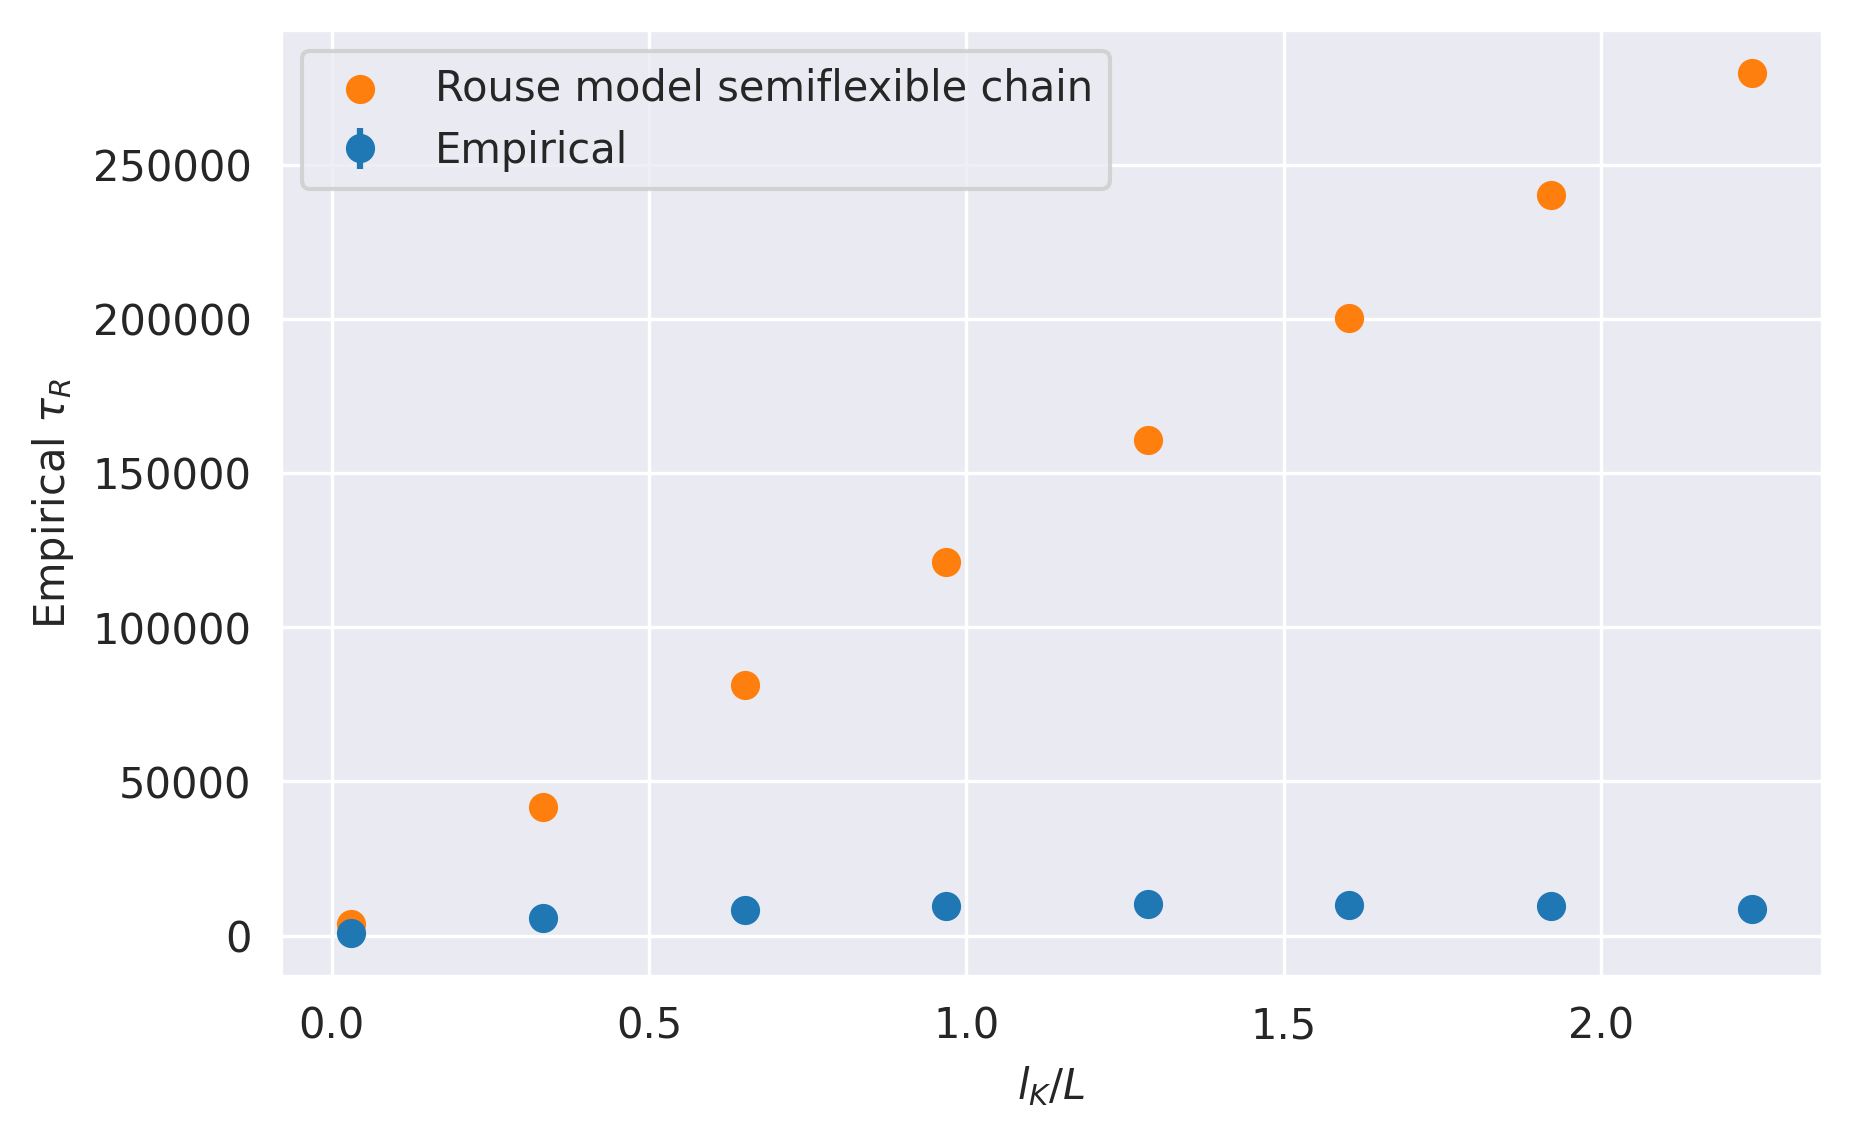

In [80]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots()

ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_R"],
    yerr=df_rouse_rimes["Empirical Delta tau_R"],
    linestyle="",
    marker="o",
    label="Empirical",
    color=sns.color_palette()[0]
)

ax.scatter(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=L_contour**2 * df_rouse_rimes["l_K"] / (2*l_b**3),
    label="Rouse model semiflexible chain",
    color=sns.color_palette()[1]
)
ax.legend()

ax.set(xlabel="$l_K/L$", ylabel="Empirical $\\tau_R$")

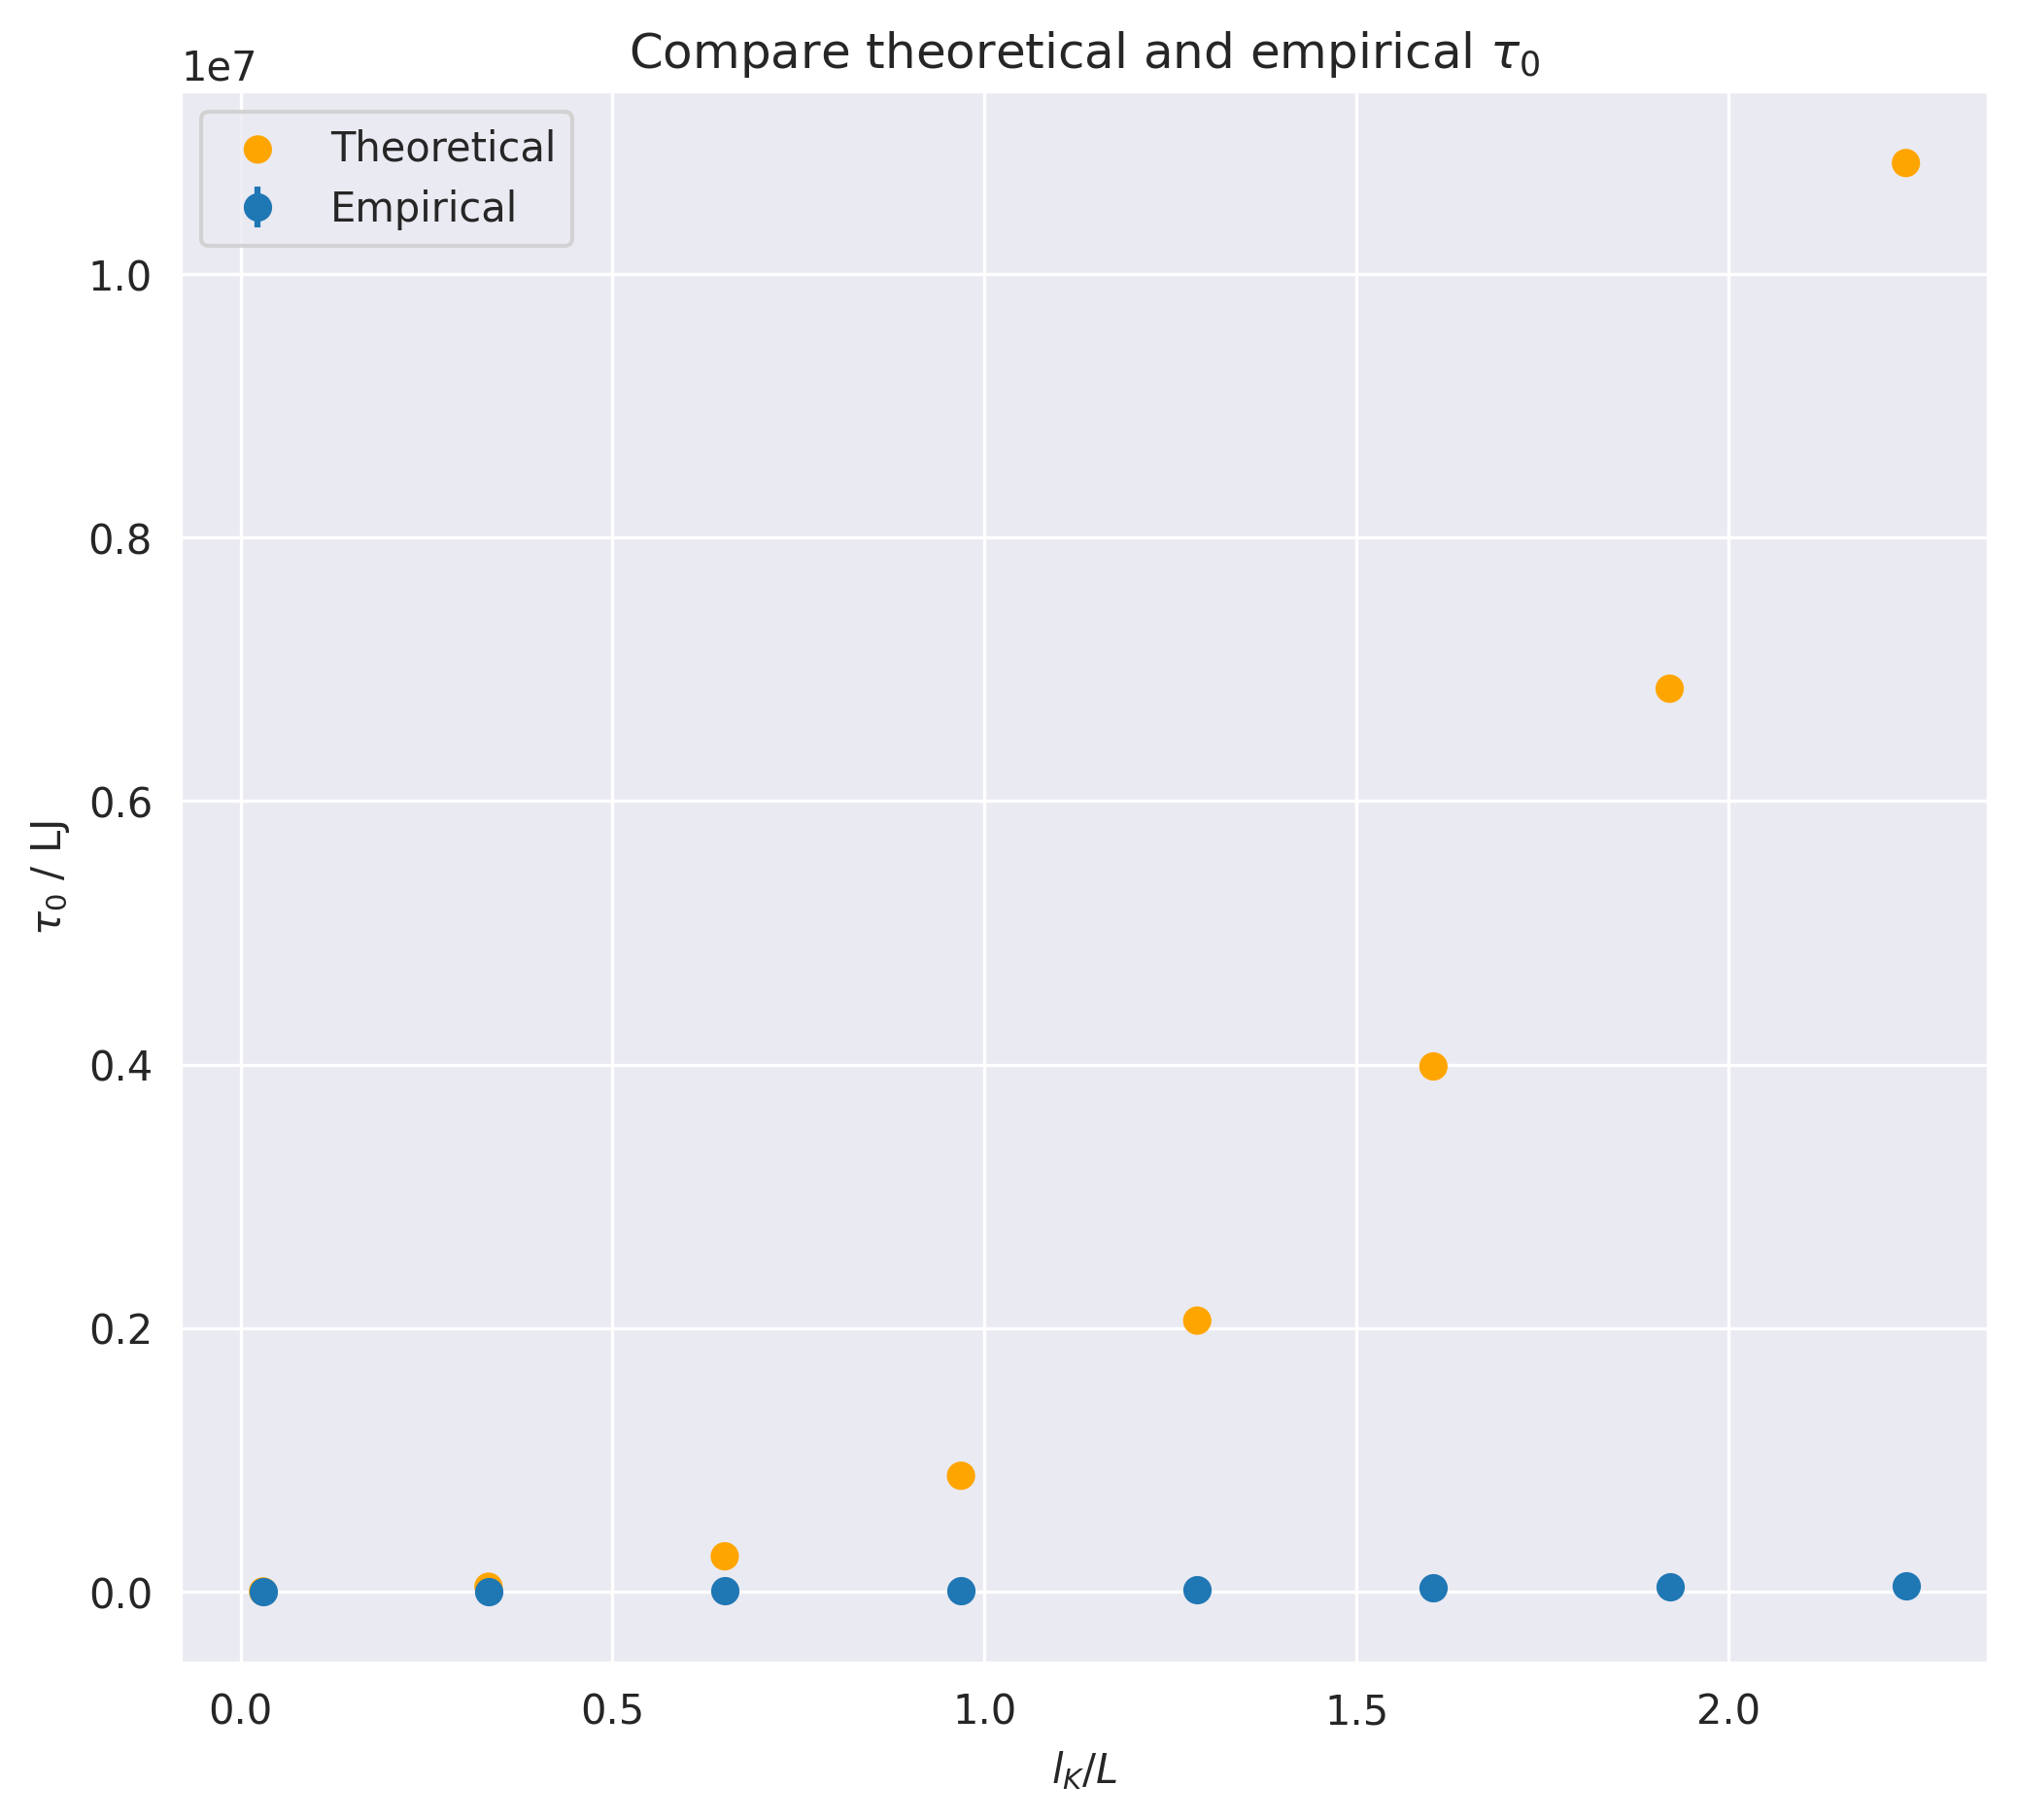

In [73]:
import matplotlib.container
import matplotlib.collections

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8, 7))

errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\tau_0$ / LJ",
    title="Compare theoretical and empirical $\\tau_0$"
)

path_coll: matplotlib.collections.PathCollection = ax.scatter(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Theory tau_0"],
    linestyle="",
    marker="o",
    label="Theoretical",
    color="orange",
)

ax.legend()

[Text(0.5, 0, '$l_K/L$'),
 Text(0, 0.5, '$\\Delta \\tau_0$ / LJ'),
 Text(0.5, 1.0, 'Empirical $\\tau_0$ - Theoretical $\\tau_0$')]

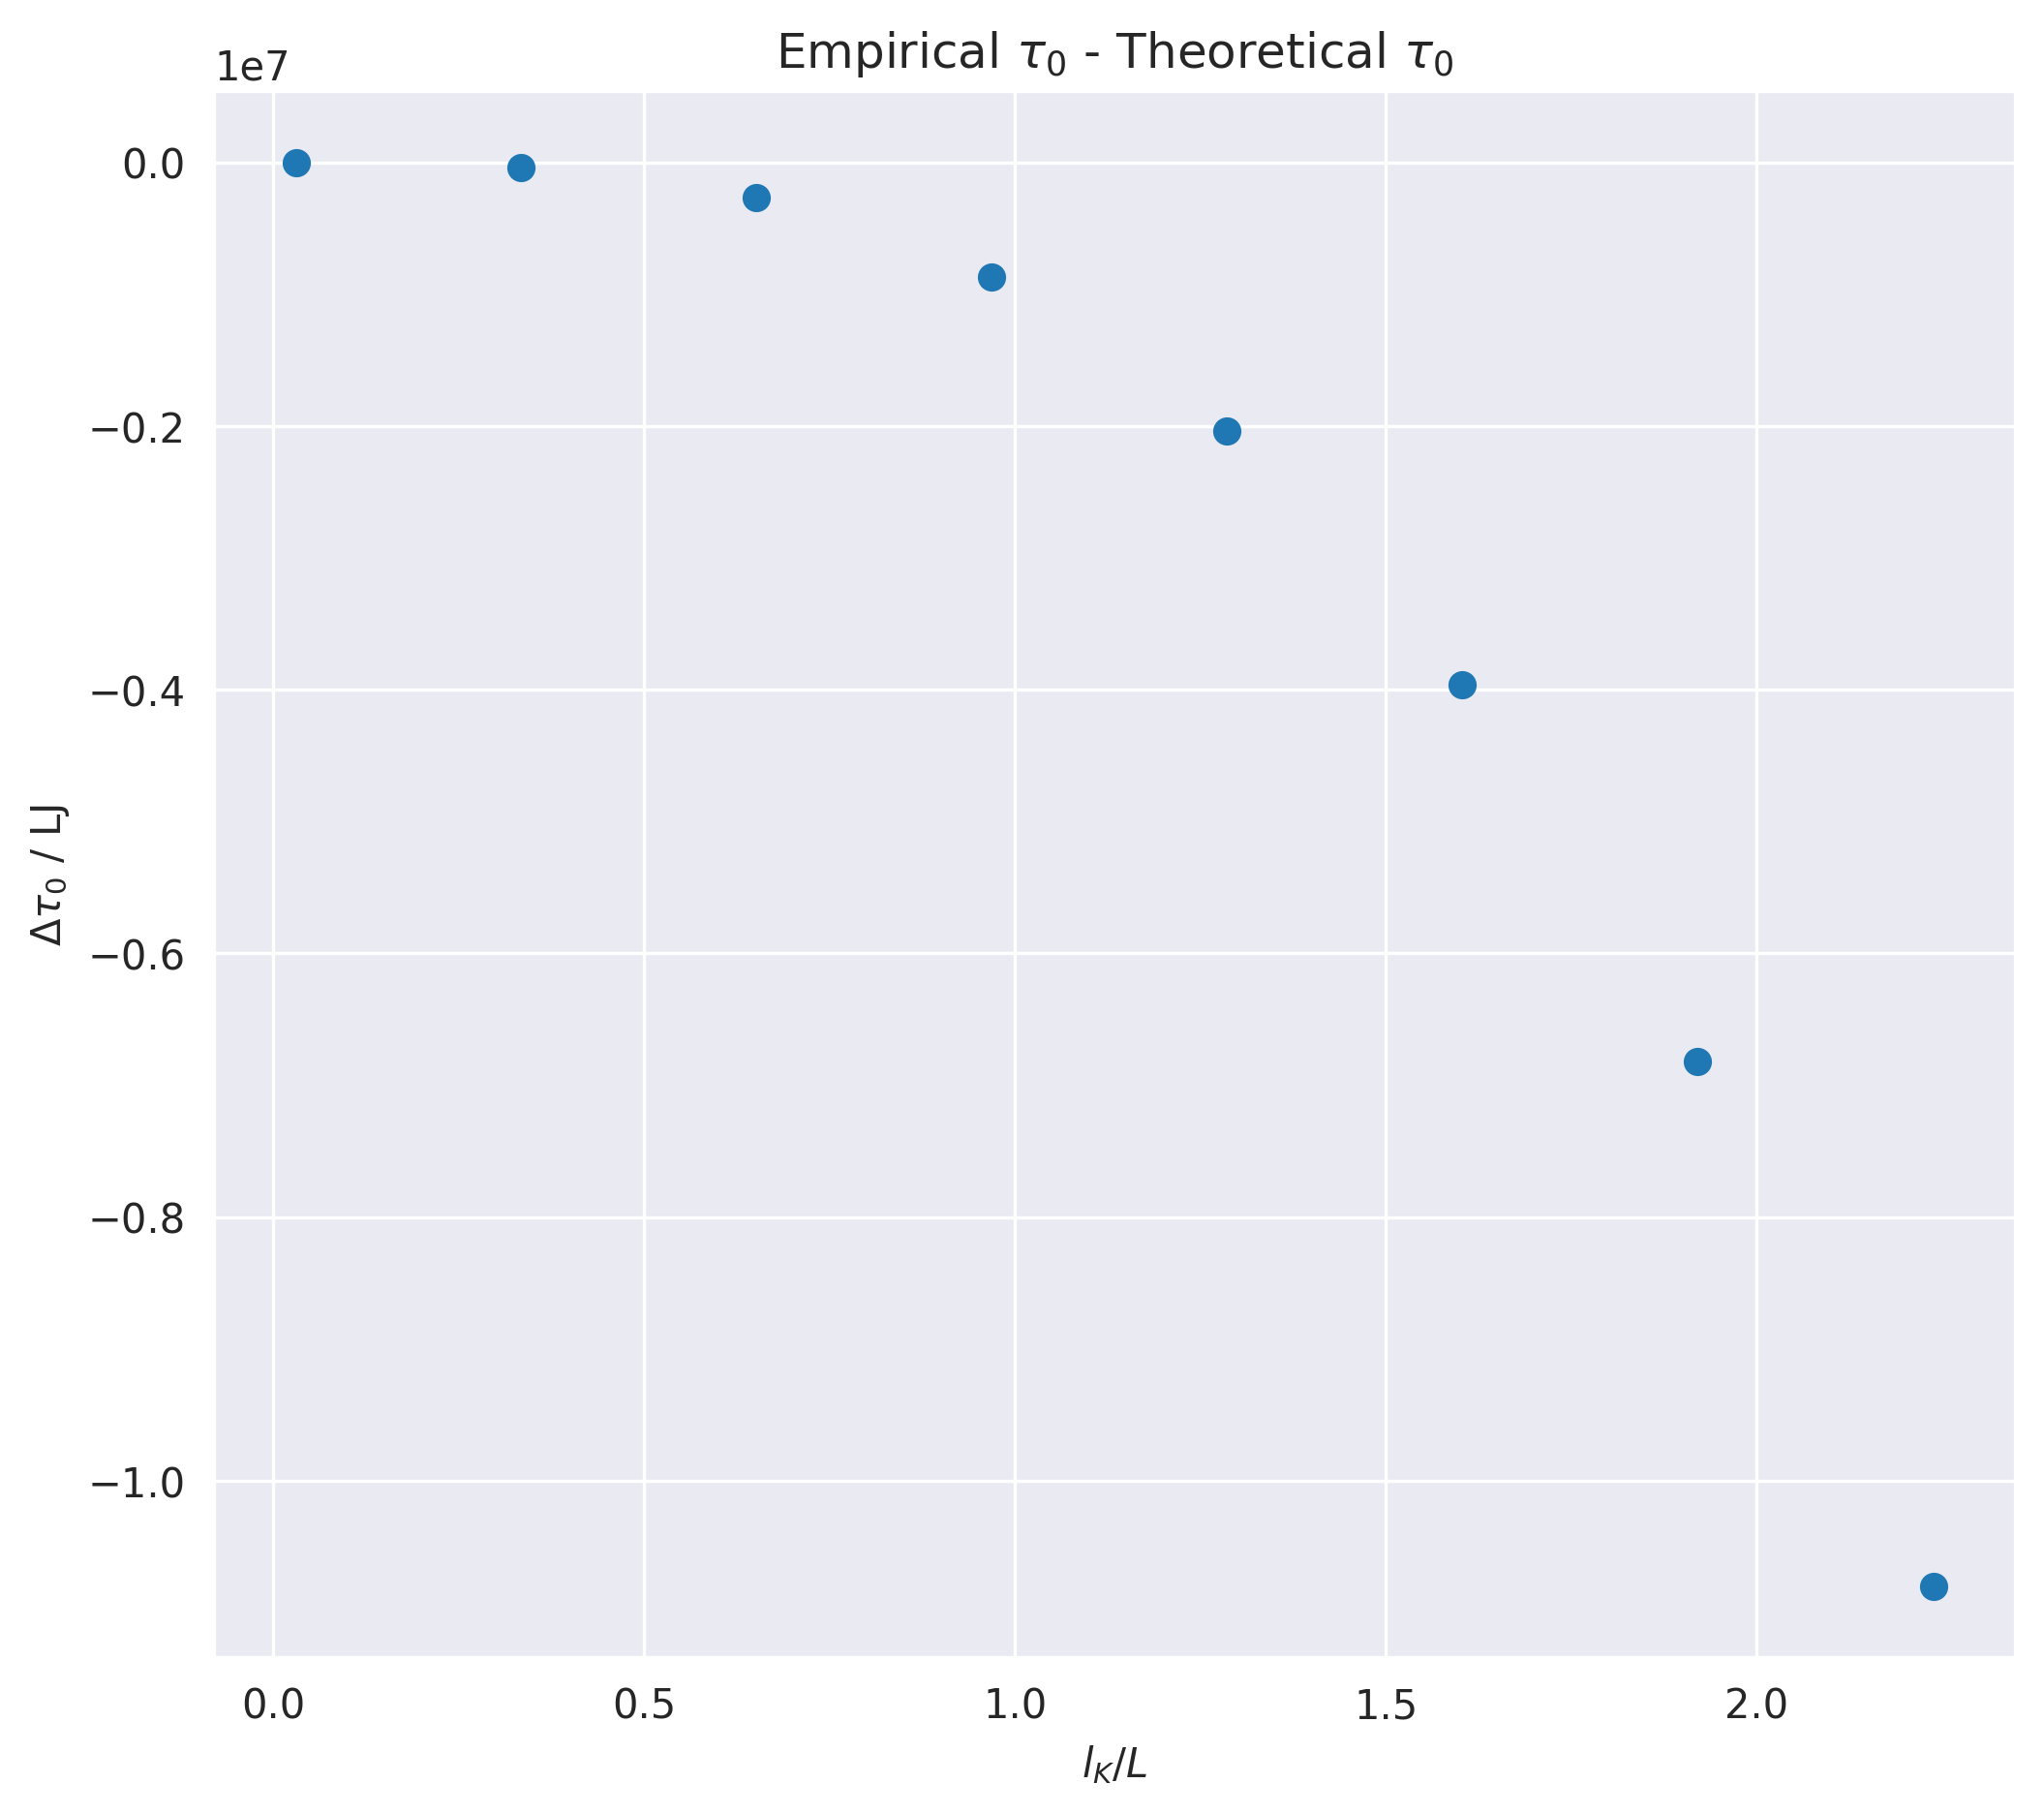

In [74]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8, 7))

errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"] - df_rouse_rimes["Theory tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical - Theory",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\Delta \\tau_0$ / LJ",
    title="Empirical $\\tau_0$ - Theoretical $\\tau_0$"
)